# Load Libraries

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import copy
import pickle
import os
from typing import Sequence

workingFolder = '/Users/kaigu/Documents/Universität/Doktorand/Projekte/KI-Regio'
os.chdir(workingFolder)

# Functions

## Feature Engineering

The following pipeline combines temporal, weather, and domain-specific features to capture patterns in pedestrian movement:

**Temporal Features**

- Base time features: Year, month, day, day of week, hour of week
- Cyclical encoding: For hour, day of week, and month
- Time blocks: Weekend indicators, rush hour, shopping hours, work hours

**Statistical & Lag Features**

- Historical averages
- Lag features

**Weather Features**

- Weather encoding: Numerical representation of weather conditions
- Temperature transformations: Squared values, normalized values
- Temperature bands: Cold (<5°C), mild (5-15°C), warm (15-25°C), hot (>25°C)

**Domain-Specific Features**

- Local events
- University patterns: Semester periods, exam periods
- Tourism indicators
- Holiday features: Public holidays, school holidays, bridge days between holidays and weekends

**Others**

In [7]:
def create_base_time_features(df):
    """
    Add basic calendar and cyclic time features.

    Builds a naive hourly `datetime` from `date` and `hour`, then derives 
    calendar fields and cyclic encodings.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns:
        - 'date' (string/datetime-like, date at day resolution)
        - 'hour' (int, 0–23 or 1–24; interpreted as hours since `date`)

    Returns
    -------
    pandas.DataFrame
        Copy of `df` with added columns:
        - 'datetime' (pd.Timestamp)
        - 'year', 'month', 'day' (int)
        - 'day_of_week' (int, Monday=0)
        - 'hour_of_week' (int, 0..167)
        - '{hour,day_of_week,month}_{sin,cos}' (float)

    Notes
    -----
    The hour is added as `pd.to_timedelta(df['hour'], 'h')`. Ensure your 'hour'
    column matches that convention (0–23 recommended).
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')
    df['year'], df['month'], df['day'] = df['datetime'].dt.year, df['datetime'].dt.month, df['datetime'].dt.day
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['hour_of_week'] = df['day_of_week'] * 24 + df['hour']
    
    for unit, period in [('hour', 24), ('day_of_week', 7), ('month', 12)]:
        df[f'{unit}_sin'] = np.sin(2 * np.pi * df[unit]/period)
        df[f'{unit}_cos'] = np.cos(2 * np.pi * df[unit]/period)
    
    return df


def create_time_block_features(df):
    """
    Add binary indicators for commonly used intraday/weekday blocks.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
        - 'day_of_week' (int, 0=Mon..6=Sun)
        - 'hour' (int, 0–23)

    Returns
    -------
    pandas.DataFrame
        Input `df` with integer {0,1} columns:
        - is_weekend, is_peak_day, is_morning_rush, is_evening_rush,
        is_rush_hour, is_shopping_hours, is_working_hours, is_lunch_time,
        is_night, is_tourist_hours
    """
    time_blocks = {
        'is_weekend': df['day_of_week'].isin([5, 6]),
        'is_peak_day': df['day_of_week'].isin([2,3,4]),
        'is_morning_rush': (df['hour'].between(7, 9)),
        'is_evening_rush': (df['hour'].between(16, 18)),
        'is_rush_hour': (df['hour'].between(7, 9) | df['hour'].between(16, 18)),
        'is_shopping_hours': (df['hour'].between(10, 19)),
        'is_working_hours': (df['hour'].between(9, 17)),
        'is_lunch_time': (df['hour'].between(11, 14)),
        'is_night': ((df['hour'] >= 22) | (df['hour'] <= 5)),
        'is_tourist_hours': (df['hour'].between(10, 18))
    }
    
    for name, condition in time_blocks.items():
        df[name] = condition.astype(int)
    return df


def create_weather_features(df):
    """
    Add weather condition one-hots and temperature-derived features.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
        - 'weather_condition' (object / category)
        - 'temperature' (numeric)

    Returns
    -------
    pandas.DataFrame
        Input `df` with added columns:
        - 'weather_*' one-hot dummies for `weather_condition` (0/1)
        - 'temp_squared' (float), 'temp_norm' (float)
        - 'temp_band' (category: cold/mild/warm/hot)
        - 'temp_*' one-hot dummies for 'temp_band' (0/1)
    """
    df = pd.concat([df, pd.get_dummies(df['weather_condition'], prefix='weather').astype(int)], axis=1)
    df['temp_squared'], df['temp_norm'] = df['temperature'] ** 2, (df['temperature'] - 15) / 10
    
    df['temp_band'] = pd.cut(df['temperature'], bins=[-np.inf, 5, 15, 25, np.inf], labels=['cold', 'mild', 'warm', 'hot'])
    df = pd.concat([df, pd.get_dummies(df['temp_band'], prefix='temp').astype(int)], axis=1)
    
    return df


def add_wuerzburg_events(df):
    """
    Merge city event and lecture indicators for Würzburg onto the hourly frame.

    Reads daily/hourly event datasets from disk, derives 'date' and 'hour',
    merges them, and flags university exam periods.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
        - 'date' (string/datetime-like)
        - 'hour' (int)
        - 'month' (int)  # used for 'is_exam_period'

    External Files
    --------------
    Expects CSV files in `os.path.join(workingFolder, 'data_general')`:
        - 'events_daily.csv'     (must have a 'date' column parsable to datetime)
        - 'lectures_daily.csv'   (daily granularity with 'date')

    Returns
    -------
    pandas.DataFrame
        `df` with columns from the merged event datasets and:
        - 'is_exam_period' (0/1) for months {1,2,7,8}

    Notes
    -----
    Requires a global `workingFolder` variable to be defined.
    """
    eventsDf = pd.read_csv(os.path.join(workingFolder, 'data_general', 'events_daily.csv'))
    lecturesDf = pd.read_csv(os.path.join(workingFolder, 'data_general', 'lectures_daily.csv'))

    # Split up date in eventsDf into date and hour
    eventsDf['hour'] = pd.to_datetime(eventsDf['date']).dt.hour.astype('int64')
    eventsDf['date'] = pd.to_datetime(eventsDf['date']).dt.date.astype('str')

    df = df.merge(eventsDf, on = ['date', 'hour'], how='left')

    df = df.merge(lecturesDf, on='date', how='left')
    
    df['is_exam_period'] = (df['month'].isin([1,2,7,8])).astype(int)
    
    return df


def add_enhanced_holiday_features(df):
    """
    Merge public/school holidays and derive bridge-day and nationwide flags.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
        - 'date' (string/datetime-like)
        - 'is_weekend' (0/1)  # used for bridge-day detection

    External Files
    --------------
    Expects CSV files in `os.path.join(workingFolder, 'data_general')`:
        - 'bavarian_public_holidays_daily.csv'  (cols: 'date', 'public_holiday', 'nationwide', ...)
        - 'bavarian_school_holidays_daily.csv'  (cols: 'date', 'school_holiday', ...)

    Returns
    -------
    pandas.DataFrame
        `df` with added/renamed columns:
        - 'is_public_holiday' (int), 'nationwide' (as provided), 'is_public_holiday_nationwide' (boolean/int)
        - 'is_school_holiday' (int)
        - 'is_bridge_day' (0/1), true when a holiday neighbors a weekend.

    Notes
    -----
    Uses `.shift(±1)` across the full DataFrame chronology to detect bridge days.
    """
    publicHolidaysDf =  pd.read_csv(os.path.join(workingFolder, 'data_general', 'bavarian_public_holidays_daily.csv'))
    schoolHolidaysDf =  pd.read_csv(os.path.join(workingFolder, 'data_general', 'bavarian_school_holidays_daily.csv'))

    df = df.merge(publicHolidaysDf, on='date', how='left')

    df['is_bridge_day'] = (
        ((df['public_holiday'].shift(1) == 1) & (df['is_weekend'] == 1)) |
        ((df['public_holiday'] == 1) & (df['is_weekend'].shift(-1) == 1))
    ).astype(int)

    df['is_public_holiday_nationwide'] = (df['public_holiday'] & df['nationwide'])

    df = df.merge(schoolHolidaysDf, on='date', how='left')

    # Rename 'public_holiday' to 'is_public_holiday' and 'school_holiday' to 'is_school_holiday'
    df.rename(columns={'public_holiday': 'is_public_holiday', 'school_holiday': 'is_school_holiday'}, inplace=True)
    
    return df


def add_timestamp(df: pd.DataFrame, date_col: str = "date", hour_col: str = "hour") -> pd.DataFrame:
    """
    Construct a naive hourly timestamp from separate date and hour columns.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain `date_col` and `hour_col`.
    date_col : str, default "date"
        Column with date-like values (day resolution).
    hour_col : str, default "hour"
        Column with integer hours; interpreted as hours since `date`.

    Returns
    -------
    pandas.DataFrame
        `df` with an added 'timestamp' (pd.Timestamp) column.

    Notes
    -----
    The hour is treated as `0..` hours offset from `date`. If your data uses 1–24,
    ensure consistency with prior feature builders.
    """
    ts = pd.to_datetime(df[date_col]) + pd.to_timedelta(df[hour_col] - 1, unit="H")
    return df.assign(timestamp=ts)


def add_rolling_lag_means(
    df: pd.DataFrame,
    value_cols: Sequence[str],
    windows_hours: Sequence[int] = (24, 48, 168),
    timestamp_col: str = "timestamp",
    min_periods: int = 1,
) -> pd.DataFrame:
    """
    Compute time-based rolling lag means per street, excluding the current hour.

    For each column in `value_cols`, adds `<col>_mean_lag{w}h` using a
    time-based window of the last `w` hours relative to each timestamp,
    applied **per streetname**, and based only on available rows within the
    window (gaps allowed). The current hour is excluded via `shift(1)`.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
        - `timestamp_col` (datetime-like)
        - 'streetname' (object)
        - all `value_cols` (numeric)
    value_cols : Sequence[str]
        Columns to aggregate.
    windows_hours : Sequence[int], default (24, 48, 168)
        Window sizes in hours (e.g., 24 for last day).
    timestamp_col : str, default "timestamp"
        Name of the timestamp column to use as index for rolling.
    min_periods : int, default 1
        Minimum number of observations in the window to compute a mean.

    Returns
    -------
    pandas.DataFrame
        DataFrame sorted by timestamp with added lag-mean columns.
        Initial NA rows (first observations per street) are dropped.
        Index is reset.

    Notes
    -----
    - Excludes the current row via `.shift(1)`.
    - Uses `'wH'` time-based windows (not fixed-size row counts).
    - Drops all rows with any NA after feature creation (`dropna()`).
    """
    if timestamp_col not in df.columns:
        raise ValueError(f"Missing '{timestamp_col}'. Call add_timestamp() first or pass the right column.")

    out = df.sort_values(timestamp_col).copy()
    out = out.set_index(timestamp_col)

    data_out = []
    for street in out['streetname'].unique():
        street_mask = out['streetname'] == street
        street_data = out[street_mask].copy()
        for col in value_cols:

            s = street_data[col].shift(1)  # exclude current hour
            for w in windows_hours:
                street_data[f"{col}_mean_lag{w}h"] = s.rolling(f"{w}H", min_periods=min_periods).mean()
        data_out.append(street_data)
        
    out = pd.concat(data_out).sort_index()
    
    # Remove all NA rows that could not be filled (e.g. first hour of each street)
    out = out.dropna().reset_index(drop = True)

    return out


def create_interaction_features(df):
    """
    Add selected pairwise interaction features.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
        - 'temperature', 'hour', 'is_weekend', 'is_shopping_hours', 'is_rush_hour'
        - 'weather_condition' (used to check for 'rain')

    Returns
    -------
    pandas.DataFrame
        Input `df` with added integer {0,1} columns:
        - 'temp_hour', 'weekend_hour', 'temp_shopping_hours',
        'rain_rush_hour', 'rain_weekend'
    """
    interactions = {
        'temp_hour': df['temperature'] * df['hour'],
        'weekend_hour': df['is_weekend'] * df['hour'],
        'temp_shopping_hours': df['temperature'] * df['is_shopping_hours'],
        'rain_rush_hour': (df['weather_condition'] == 'rain') & df['is_rush_hour'],
        'rain_weekend': (df['weather_condition'] == 'rain') & df['is_weekend']
    }
    
    for name, interaction in interactions.items():
        df[name] = interaction.astype(int)
    return df


def add_street_features(df):
    """
    One-hot encode street names and add street-specific time block interactions.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
        - 'streetname' (object)
        - 'is_shopping_hours', 'is_rush_hour' (0/1)

    Returns
    -------
    pandas.DataFrame
        Input `df` with:
        - 'street_*' one-hot dummies (0/1)
        - street × shopping/rush interaction flags for
        {'kaiserstrasse','schoenbornstrasse','spiegelstrasse'}
    """
    df = pd.concat([df, pd.get_dummies(df['streetname'], prefix='street').astype(int)], axis=1)
    
    df['is_kaiserstrasse_shopping'] = ((df['streetname'] == 'kaiserstrasse') & (df['is_shopping_hours'] == 1)).astype(int)
    df['is_schoenbornstrasse_shopping'] = ((df['streetname'] == 'schoenbornstrasse') & (df['is_shopping_hours'] == 1)).astype(int)
    df['is_spiegelstrasse_shopping'] = ((df['streetname'] == 'spiegelstrasse') & (df['is_shopping_hours'] == 1)).astype(int)

    df['is_kaiserstrasse_rush'] = ((df['streetname'] == 'kaiserstrasse') & (df['is_rush_hour'] == 1)).astype(int)
    df['is_schoenbornstrasse_rush'] = ((df['streetname'] == 'schoenbornstrasse') & (df['is_rush_hour'] == 1)).astype(int)
    df['is_spiegelstrasse_rush'] = ((df['streetname'] == 'spiegelstrasse') & (df['is_rush_hour'] == 1)).astype(int)
    
    return df


def create_seasonal_features(df):
    """
    Add coarse COVID period flags and seasonal/tourism indicators.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
        - 'date' (string/period-like, compared as strings 'YYYY-MM')
        - 'month' (int)
        - 'is_weekend' (0/1)

    Returns
    -------
    pandas.DataFrame
        Input `df` with added columns:
        - 'covid_lockdown', 'covid_lockdown_lift', 'covid_lull', 'post_covid_recovery' (0/1)
        - 'season' (category: winter/spring/summer/fall)
        - 'season_*' one-hot dummies (0/1)
        - 'is_tourist_season', 'is_weekend_tourist_season' (0/1)

    Notes
    -----
    Date range checks are string comparisons ('YYYY-MM'), not full timestamps.
    """
    df['covid_lockdown'] = ((df['date'] >= '2020-03') & (df['date'] <= '2020-06')).astype(int)
    df['covid_lockdown_lift'] = ((df['date'] >= '2020-06') & (df['date'] <= '2021-05')).astype(int)
    df['covid_lull'] = ((df['date'] >= '2021-06') & (df['date'] <= '2022-04')).astype(int)
    df['post_covid_recovery'] = ((df['date'] >= '2022-05') & (df['date'] <= '2022-12')).astype(int)

    df['season'] = pd.cut(df['month'], bins=[0,3,6,9,12], labels=['winter','spring','summer','fall'])
    df = pd.concat([df, pd.get_dummies(df['season'], prefix='season').astype(int)], axis=1)
    
    df['is_tourist_season'] = df['month'].isin([5,6,7,8,9,10]).astype(int)
    df['is_weekend_tourist_season'] = (df['is_weekend'] & df['is_tourist_season']).astype(int)
    return df


def get_feature_columns(df):
    """
    Select numeric feature columns for modeling.

    Excludes identifier/time/meta columns and raw categoricals that have been
    replaced by dummies.

    Parameters
    ----------
    df : pandas.DataFrame

    Returns
    -------
    list of str
        Column names to use as features.

    Side Effects
    ------------
    Prints the set of removed columns for transparency.

    Notes
    -----
    Excludes:
    ['id','datetime','date','timestamp','streetname','city',
    'n_pedestrians','n_pedestrians_towards','n_pedestrians_away',
    'weather_condition','temp_band','season']
    """
    # weather_condition', 'temp_band', 'season' are replaced by dummies
    exclude_cols = ['id', 'datetime', 'date', 'weekday', 'timestamp', 'streetname', 'city',
                'n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away',
                'weather_condition', 'temp_band', 'season']
    
    feature_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]
    
    # Get the difference between df.columns and feature_cols and print all removed columns
    removed_cols = set(df.columns) - set(feature_cols)
    print(f'Removed columns: {removed_cols}')
    
    return feature_cols


def create_all_features(df):
    """
    End-to-end feature builder for hourly pedestrian forecasting.

    Runs base/time/weather/seasonal/event features, timestamp and lag means,
    holiday enhancements, interactions, and street features. Finally removes
    selected categoricals and label-encodes remaining object columns (except
    identifiers).

    Parameters
    ----------
    df : pandas.DataFrame
        Minimum required columns:
        - 'date', 'hour', 'month', 'day_of_week', 'streetname'
        - 'weather_condition', 'temperature'
        - Any columns required by the merged CSVs (events/holidays)

    Returns
    -------
    pandas.DataFrame
        Feature-augmented frame ready for model input.

    Notes
    -----
    - Order matters only after timestamp creation; rolling features require 'timestamp'.
    - Drops raw 'city','weather_condition','temp_band','season' if present.
    - Label-encodes remaining object columns except ['id','streetname','date'].
    - Relies on external CSVs and a global `workingFolder` for merges.
    """
    # The following functions don't need to be executed in a specific order
    df = create_base_time_features(df)
    df = create_time_block_features(df)
    df = create_weather_features(df)
    df = create_seasonal_features(df)
    df = add_wuerzburg_events(df)
    df = add_timestamp(df)
    
    # The following functions have to be executed after all previous ones, e.g., add_rolling_lag_means needs timestamp    
    df = add_rolling_lag_means(df, value_cols=['temperature'])
    df = add_enhanced_holiday_features(df)
    df = create_interaction_features(df)
    df = add_street_features(df)
    
    #---
    
    ###### FURTHER PROCESSING ######
    
    # Remove 'city', 'weather_condition', 'temp_band', 'season' from df if they exist
    for col in ['city', 'weather_condition', 'temp_band', 'season']:
        if col in df.columns:
            df = df.drop(columns=[col])

    # Encode categorical/object columns that are not id, streetname, date and process them with LabelEncoder
    le = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        if col not in ['id', 'streetname', 'date',]:
            print(f'Encoding {col}')
            df[f'{col}_encoded'] = le.fit_transform(df[col])


    return df


## Modeling Functions

In [8]:
from typing import Optional


def get_cv_splits(df, n_splits=5, len_split=168):
    """
    Build blocked, **time-ordered** cross-validation splits per street.

    For each split i (0..n_splits-1), the validation window is the last
    `len_split` rows of each street shifted i blocks back in time.
    The training set is everything strictly before that window, again per street.
    Index arrays from the original (reset) DataFrame are returned so they can be
    fed directly into scikit-learn CV routines.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain a 'streetname' column. Assumed to be **chronologically sorted**
        within each street.
    n_splits : int, default 5
        Number of rolling validation windows to produce from the end of the series.
    len_split : int, default 168
        Length of each validation window in rows (e.g., 168 = one week of hourly data).

    Returns
    -------
    list[tuple[np.ndarray, np.ndarray]]
        A list of (train_idx, val_idx) tuples (integer indices) for each split.

    Notes
    -----
    - No leakage: validation windows are strictly after the corresponding train windows.
    - If a street has fewer than (i+1)*len_split rows, the split for that street
    will yield an empty train or val segment; ensure your data is long enough.
    """
    df.reset_index(drop=True, inplace=True)

    cv_splits = []

    for i in range(n_splits):

        ids_train = []
        ids_val = []

        for street in df.streetname.unique():
            street_mask = df.streetname == street
            df_street = df[street_mask]

            len_street = df_street.shape[0]

            split_point = len_street - len_split * (i + 1)
            end_point = len_street - len_split * i
            
            ids_train.append(df_street.iloc[:split_point, :].index)
            ids_val.append(df_street.iloc[split_point:end_point, :].index)
            
        ids_train = np.concatenate(ids_train, axis=0)
        ids_val = np.concatenate(ids_val, axis=0)

        cv_splits.append((ids_train, ids_val))
    
    return cv_splits



def tune_model_random(model, param_dist, X, y, cv_splits, n_iter=50, n_jobs=8, verbose=1):
    """
    Randomized hyperparameter search with custom time-based splits.

    Wraps `sklearn.model_selection.RandomizedSearchCV` using negative MSE,
    fits on (X, y), and returns the fitted search object.

    Parameters
    ----------
    model : sklearn.base.BaseEstimator
        Estimator supporting `fit` and (optionally) `predict`.
    param_dist : dict or list[dict]
        Parameter distributions for RandomizedSearchCV.
    X : array-like or pandas.DataFrame
        Training features.
    y : array-like or pandas.Series
        Target values aligned with X.
    cv_splits : list[tuple[np.ndarray, np.ndarray]]
        Output from `get_cv_splits` or similar [(train_idx, val_idx), ...].
    n_iter : int, default 50
        Number of parameter settings sampled.
    n_jobs : int, default 8
        Parallel jobs for the CV search.
    verbose : int, default 1
        Verbosity level passed to RandomizedSearchCV.

    Returns
    -------
    sklearn.model_selection.RandomizedSearchCV
        The fitted search object (`best_estimator_`, `best_params_`, etc. available).

    Notes
    -----
    - Scoring is 'neg_mean_squared_error' (larger is better). Use `-cv.best_score_`
    to get the MSE.
    """

    cv = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='neg_mean_squared_error',
        cv=cv_splits,
        refit=True,
        n_jobs=n_jobs,
        verbose=verbose)
    
    cv.fit(X, y)
    
    return cv



def tune_model_bayes(model, param_dist, X, y, cv_splits, n_iter=50, n_points=1, n_jobs=8, verbose=1):
    """
    Bayesian hyperparameter optimization with custom time-based splits.

    Uses `skopt.BayesSearchCV` (scikit-optimize) to search `param_dist`
    under negative MSE, fits on (X, y), and returns the fitted search object.

    Parameters
    ----------
    model : sklearn.base.BaseEstimator
        Estimator supporting `fit`.
    param_dist : dict or list[skopt.space.Dimension]
        Search space for BayesSearchCV.
    X : array-like or pandas.DataFrame
        Training features.
    y : array-like or pandas.Series
        Targets aligned with X.
    cv_splits : list[tuple[np.ndarray, np.ndarray]]
        Output from `get_cv_splits` or similar.
    n_iter : int, default 50
        Total number of parameter evaluations.
    n_points : int, default 1
        Number of parameter settings to sample in parallel per iteration.
    n_jobs : int, default 8
        Parallel jobs for model fitting in each CV fold.
    verbose : int, default 1
        Verbosity level passed to BayesSearchCV.

    Returns
    -------
    skopt.BayesSearchCV
        The fitted search object (`best_estimator_`, `best_params_`, etc.).

    Notes
    -----
    - Scoring is 'neg_mean_squared_error'. Convert to MSE via `-cv.best_score_`.
    - `random_state` is fixed at 42 for reproducibility.
    """

    cv = BayesSearchCV(
        estimator=model,
        search_spaces=param_dist,
        n_iter=n_iter,
        n_points=n_points,
        scoring='neg_mean_squared_error',
        cv=cv_splits,
        n_jobs=n_jobs,
        verbose=verbose,
        random_state=42)
    
    cv.fit(X, y)
    
    return cv



def get_best_model(models_dict, y_true, val_predictions_dict):
    """
    Pick the model with the lowest MSE on a shared validation target.

    Parameters
    ----------
    models_dict : dict[str, sklearn.base.BaseEstimator]
        Mapping from model name to fitted model (or any identifier).
    y_true : array-like
        Ground-truth validation targets.
    val_predictions_dict : dict[str, array-like or pandas.Series]
        Mapping from model name to its predictions aligned with `y_true`.

    Returns
    -------
    tuple[str, float]
        (best_model_name, best_mse)

    Notes
    -----
    - Assumes `val_predictions_dict[model_name]` is 1-D and index-aligned with `y_true`.
    """
    best_mse, best_model = float('inf'), None
    
    for model_name, model in models_dict.items():
        mse = mean_squared_error(y_true, val_predictions_dict[model_name])
        if mse < best_mse:
            best_mse, best_model = mse, model_name
    
    return best_model, best_mse





def create_metrics_table(y_true, predictions_dict, target_col):
    """
    Build a small metrics table (per model) with common regression scores.

    Parameters
    ----------
    y_true : array-like or pandas.Series
        Ground-truth targets.
    predictions_dict : dict[str, pandas.DataFrame]
        For each model name, a DataFrame containing a column `target_col`
        with predictions aligned to `y_true`.
    target_col : str
        Name of the prediction column inside each predictions DataFrame.

    Returns
    -------
    pandas.DataFrame
        Rows per model with columns: 'Model', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2'.
        Values are **formatted strings** (e.g., "123.45", "12.34%", "0.8765").

    Notes
    -----
    - MAPE uses `np.mean(abs((y_true - y_pred)/y_true))`. If `y_true` contains zeros,
    this will yield inf/NaN; consider filtering or using SMAPE for robustness.
    """
    return pd.DataFrame([{
        'Model': model_name.upper(),
        'MSE': f"{(mean_squared_error(y_true, preds[target_col])):.2f}",
        'RMSE': f"{np.sqrt(mean_squared_error(y_true, preds[target_col])):.2f}",
        'MAE': f"{(mean_absolute_error(y_true, preds[target_col])):.2f}",
        'MAPE': f"{(np.mean(np.abs((y_true - preds[target_col]) / y_true)) * 100):.2f}%",
        'R2': f"{r2_score(y_true, preds[target_col]):.4f}"
    } for model_name, preds in predictions_dict.items()])



def create_street_metrics(val_df, predictions_dict, target_col):
    """
    Compute the same metrics as `create_metrics_table` **per street**.

    Parameters
    ----------
    val_df : pandas.DataFrame
        Validation frame with columns:
        - 'streetname'
        - `target_col` (ground-truth)
        Must be index-aligned with the predictions in `predictions_dict`.
    predictions_dict : dict[str, pandas.DataFrame]
        For each model name, a DataFrame with a column `target_col` whose index
        matches `val_df.index` (so boolean masks can be applied).
    target_col : str
        Name of the target/prediction column.

    Returns
    -------
    dict[str, pandas.DataFrame]
        Mapping from street name → metrics table (one row per model).

    Notes
    -----
    - Assumes all predictions are aligned to `val_df` so that `loc[street_mask]`
    selects the right rows.
    - Tip: If you want numeric metrics instead of formatted strings, adapt
    `create_metrics_table` accordingly.
    """
    
    street_mask = val_df['streetname'] == street
    
    return {street: create_metrics_table(
        val_df[street_mask][target_col],
        {model_name: pd.DataFrame({target_col: preds.loc[street_mask, target_col]}) 
        for model_name, preds in predictions_dict.items()},
        target_col
    ) for street in val_df['streetname'].unique()}




# def compute_seasonal_factors(train_df: pd.DataFrame,
#                             target: str,
#                             keys: Optional[Sequence[str]] = None) -> pd.DataFrame:
#     """
#     Compute multiplicative (or additive) seasonal factors as the mean target by keys.

#     Parameters
#     ----------
#     train_df : pandas.DataFrame
#         Training subset used to compute factors.
#     target : str
#         Target column to average.
#     keys : sequence of str | None
#         Grouping keys. If None, uses ['streetname', weekday_col, 'hour'].

#     Returns
#     -------
#     pandas.DataFrame
#         Keys + 'seasonal_factors' column (mean target).
#     """
#     if keys is None:
#         keys = ['streetname', 'weekday', 'hour']
        
#     seasonal_factors = (train_df
#         .groupby(list(keys))[target]
#         .mean()
#         .reset_index()
#         .rename({target: 'seasonal_factors'}, axis=1))
    
#     return seasonal_factors


# def apply_deseasonalization(df: pd.DataFrame,
#                             seasonal_factors: pd.DataFrame,
#                             target: str,
#                             keys: Optional[Sequence[str]] = None,
#                             mode: str = "subtract") -> pd.DataFrame:
#     """
#     Join seasonal factors and apply (de)seasonalization.

#     Parameters
#     ----------
#     df : pandas.DataFrame
#         Data to transform (train/val/test/submission).
#     factors : pandas.DataFrame
#         Output of `compute_seasonal_factors`.
#     target : str
#         Target column name to adjust (must exist in df to subtract/add).
#     keys : sequence of str | None
#         Join keys. If None, ['streetname', weekday_col, 'hour'] is used.
#     mode : {'subtract','add'}
#         'subtract' to deseasonalize, 'add' to restore.

#     Returns
#     -------
#     pandas.DataFrame
#         A copy with 'seasonal_factors' merged and target adjusted accordingly.
#     """
#     if keys is None:
#         keys = ['streetname', 'weekday', 'hour']
#     out = df.merge(seasonal_factors, on=list(keys), how='left')
    
#     if mode == "subtract":
#         out[target] = out[target] - out['seasonal_factors']
        
#     elif mode == "add":
#         out[target] = out[target] + out['seasonal_factors']
        
#     else:
#         raise ValueError("mode must be 'subtract' or 'add'")
    
#     # Drop 'seasonal_factors' again
#     out = out.drop(columns=['seasonal_factors'])
    
#     return out


## Plot Functions

In [9]:
def display_model_comparison(val_df, val_predictions, test_predictions, best_models):
    """
    Print overall and per-street validation metrics for all targets, plus the selected best model.

    Parameters
    ----------
    val_df : pandas.DataFrame
        Validation dataframe containing the true targets and a 'streetname' column.
    val_predictions : dict[str, dict[str, pandas.DataFrame]]
        Mapping: target -> (model_name -> predictions_df). Each predictions_df must
        contain the target column with index aligned to `val_df`.
    test_predictions : dict[str, dict[str, pandas.DataFrame]]
        Mapping: target -> (model_name -> predictions_df) for test data.
        (Used only for completeness in this display routine.)
    best_models : dict[str, str]
        Mapping: target -> best model name (e.g., 'xgb').

    Returns
    -------
    None
        Prints formatted tables to stdout.

    Notes
    -----
    Uses `create_metrics_table` for overall metrics and `create_street_metrics`
    for per-street metrics. Assumes targets:
    ['n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away'].
    """
    for target in ['n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away']:
        print(f"\n{'='*80}\nResults for {target}\n{'='*80}\n")
        
        print("Overall Metrics:")
        print(create_metrics_table(val_df[target], val_predictions[target], target).to_string(index=False))
        print("\nStreet-wise Metrics:")
        
        for street, metrics in create_street_metrics(val_df, val_predictions[target], target).items():
            print(f"\n{street}:")
            print(metrics.to_string(index=False))
        
        if target in best_models:
            print(f"\nBest Model Selected: {best_models[target].upper()}")
        print('-'*80)



def display_feature_importance(model, feature_cols, model_name, target):
    """
    Print the top 10 feature importances for a fitted model.

    Parameters
    ----------
    model : object
        Fitted model exposing `feature_importances_` (e.g., tree-based models).
    feature_cols : list[str]
        Feature names aligned with the model's input order.
    model_name : str
        Identifier (e.g., 'xgb', 'rf', 'lgb').
    target : str
        Target name for labeling.

    Returns
    -------
    None
        Prints a sorted table (top 10) to stdout.

    Notes
    -----
    If the estimator does not provide `feature_importances_`, this will raise
    an AttributeError.
    """
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTop 10 Important Features for {model_name.upper()} - {target}:")
    print(importance_df.head(10).to_string(index=False))
    print()


def display_target_metrics(val_df, predictions, target):
    """
    Print overall and per-street validation metrics for a single target.

    Parameters
    ----------
    val_df : pandas.DataFrame
        Validation dataframe with columns:
        - 'streetname'
        - target (true values for this target).
    predictions : dict[str, pandas.DataFrame]
        Mapping: model_name -> predictions_df. Each predictions_df must contain
        a column named `target` with index aligned to `val_df`.
    target : str
        Target column name (e.g., 'n_pedestrians').

    Returns
    -------
    None
        Prints formatted tables to stdout.

    Notes
    -----
    Uses `create_metrics_table` for overall metrics, then computes the same
    metrics per street using mask-based alignment.
    """
    print(f"\n{'='*80}\nResults for {target}\n{'='*80}\n")
    
    print("Overall Metrics:")
    print(create_metrics_table(val_df[target], predictions, target).to_string(index=False))
    print("\nStreet-wise Metrics:")
    
    for street in val_df['streetname'].unique():
        print(f"\n{street}:")
        mask = val_df['streetname'] == street
        street_preds = {model: pd.DataFrame({target: preds.loc[mask, target]}) for model, preds in predictions.items()}
        print(create_metrics_table(val_df[mask][target], street_preds, target).to_string(index=False))



def plot_model_comparison(val_df, predictions_dict, test_df, test_predictions_dict, val_test_actuals, target_col):
    """
    Plot actuals and model predictions over time for each street (validation + test).

    Produces one subplot per street. Each subplot shows:
    - Validation actuals (solid blue)
    - Validation+test actuals overlay (dashed blue) from `val_test_actuals`
    - Model predictions on validation (dashed, colored by model)
    - Model predictions on test (dotted, colored by model)
    - A vertical line marking the start of the test period

    Parameters
    ----------
    val_df : pandas.DataFrame
        Validation data with columns: 'streetname', 'datetime', target_col.
    predictions_dict : dict[str, pandas.DataFrame]
        Mapping: model_name -> predictions on validation (must have target_col, index aligned to val_df).
    test_df : pandas.DataFrame
        Test data with columns: 'streetname', 'datetime', target_col (if available for display).
    test_predictions_dict : dict[str, pandas.DataFrame]
        Mapping: model_name -> predictions on test (must have target_col, index aligned to test_df).
    val_test_actuals : pandas.DataFrame
        Frame containing actuals for the combined val/test period with columns:
        'streetname', 'datetime', target_col. (If not fully available, plot will still run.)
    target_col : str
        Target column to plot (e.g., 'n_pedestrians').

    Returns
    -------
    None
        Displays the matplotlib figure.

    Notes
    -----
    - Colors for models are mapped via: {'rf': 'red', 'lgb': 'green', 'xgb': 'purple'}.
    If you use other model keys, extend the mapping or let matplotlib auto-assign.
    - Assumes `val_df` and `test_df` are time-sorted per street.
    """
    n_streets = len(val_df['streetname'].unique())
    fig, axes = plt.subplots(n_streets, 1, figsize=(20, 8*n_streets))
    if n_streets == 1: axes = [axes]
    colors = {'rf': 'red', 'lgb': 'green', 'xgb': 'purple'}
    
    for ax, street in zip(axes, val_df['streetname'].unique()):
        street_mask = val_df['streetname'] == street
        ax.plot(val_df[street_mask]['datetime'], val_df[street_mask][target_col], label='Actual', color='blue', alpha=0.7)

        val_test_mask = val_test_actuals['streetname'] == street
        ax.plot(val_test_actuals[val_test_mask]['datetime'], val_test_actuals.loc[val_test_mask, target_col], label='Actual (Val, Test)', color='blue', linestyle='--', alpha=0.7)
        
        for model_name in predictions_dict.keys():
            ax.plot(val_df[street_mask]['datetime'], predictions_dict[model_name].loc[street_mask, target_col], 
                    label=f'{model_name.upper()} (Train)', color=colors.get(model_name, None), linestyle='--', alpha=0.7)
            
            test_mask = test_df['streetname'] == street
            ax.plot(test_df[test_mask]['datetime'], test_predictions_dict[model_name].loc[test_mask, target_col],
                    label=f'{model_name.upper()} (Val, Test)', color=colors.get(model_name, None), linestyle=':', alpha=0.7)

        min_test_date = test_df['datetime'].min()
        ax.axvline(x=min_test_date, color='black', linestyle='-', alpha=0.3)
        ax.text(min_test_date, ax.get_ylim()[1], 'Test Period Start', rotation=90, verticalalignment='top')
        
        if (target_col == 'n_pedestrians'):
            ax.set_title(f"Number of Pedestrians - {street.capitalize()}", fontsize=18)
        elif (target_col == 'n_pedestrians_towards'):
            ax.set_title(f"Number of Pedestrians Towards - {street.capitalize()}", fontsize=18)
        else:
            ax.set_title(f"Number of Pedestrians Away - {street.capitalize()}", fontsize=18)

        ax.set_xlabel('Date', fontsize = 16)
        ax.set_ylabel('Number of Pedestrians', fontsize = 16)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 12)
        ax.grid(True)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, fontsize = 14)

    # plt.suptitle(f'Model Comparison for {target_col} - RMSE Scaled: {rmse_scaled:.2f}', fontsize=16)
    
    plt.tight_layout()
    plt.show()


# Execute Code

## Load Data

`test_df_submission` is being used to generate the submission file for the kaggle competition. It contains both the public and private test data. 
`test_df`, on the other hand, is being used as the internal test data for this script for plotting purposes. We need this differentiation to be able to train and evaluate on the public leaderboard data and still smoothly generate our submission file.

In [12]:
train_df = pd.read_csv(os.path.join(workingFolder, 'kaggle_v2/data_foot_traffic', 'train.csv'))
test_df = pd.read_csv(os.path.join(workingFolder, 'kaggle_v2/data_foot_traffic', 'test.csv'))
solution_df = pd.read_csv(os.path.join(workingFolder, 'kaggle_v2/data_foot_traffic', 'solution.csv'))

X_publicTest = test_df[test_df['id'].isin(solution_df[solution_df.Usage == 'Public'].id)]
X_publicTest = X_publicTest.merge(solution_df[solution_df.Usage == 'Public'], on='id', how='left')
X_publicTest.drop(columns=['Usage'], inplace=True)

test_df_submission = copy.deepcopy(test_df)

val_test_actuals = pd.read_csv(os.path.join(workingFolder, 'kaggle_v2/data_foot_traffic', 'val_test_actuals.csv'))

In [13]:
# OPTIONAL: Use public kaggle data as training data
train_df = pd.concat([train_df, X_publicTest], ignore_index=True).reset_index(drop=True)

# Remove all ids that are part of X_public from test_df
test_df = test_df[~test_df['id'].isin(X_publicTest['id'])].reset_index(drop=True)

## Feature Engineering

In [14]:
print("Creating training features...")
train_df = create_all_features(train_df)


print("Creating test features...")
test_df = create_all_features(test_df)

print("Creating test submission features...")
test_df_submission = create_all_features(test_df_submission)

val_test_actuals = create_base_time_features(val_test_actuals)

#---

# OPTIONAL: Removal of datapoints 

# Remove all data that is after 2020-03 and before 2022-06
train_df = train_df[(train_df['date'] < '2020-03') | (train_df['date'] > '2022-06')]

# Remove all features that contain the word 'covid'
train_df = train_df.loc[:, ~train_df.columns.str.contains('covid')]
test_df = test_df.loc[:, ~test_df.columns.str.contains('covid')]

# Remove all observations with incidents_encoded != 2 und collection_type_encoded != 0
train_df = train_df[(train_df['incidents_encoded'] == 2) & (train_df['collection_type_encoded'] == 0)].reset_index(drop=True)
train_df = train_df.drop(columns=['incidents_encoded', 'collection_type_encoded'])

#---

feature_cols_train = get_feature_columns(train_df)
feature_cols_test = get_feature_columns(test_df)

# Use the intersection of both feature sets to ensure compatibility
feature_cols = list(set(feature_cols_train).intersection(set(feature_cols_test)))
print(f"Using {len(feature_cols)} features: {feature_cols}")

for col in feature_cols:
    if train_df[col].isnull().any():
        print(f"Warning: Missing values in column {col}")
        train_df[col] = train_df[col].fillna(train_df[col].mean())
        test_df[col] = test_df[col].fillna(train_df[col].mean())

train_df['date'] = pd.to_datetime(train_df['date'])
last_date = train_df['date'].max()
cutoff_date = last_date - pd.DateOffset(months=16)
val_start_date = last_date - pd.DateOffset(months=0, weeks=1)

train_mask = (train_df['date'] >= cutoff_date) & (train_df['date'] < val_start_date)
X_train = train_df[train_mask]
X_val = train_df[train_df['date'] >= val_start_date]


Creating training features...


/var/folders/lr/3vgp2f3j5xg_q_5y32dvhb3w0000gn/T/ipykernel_81197/3337856985.py:228: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  ts = pd.to_datetime(df[date_col]) + pd.to_timedelta(df[hour_col] - 1, unit="H")
/var/folders/lr/3vgp2f3j5xg_q_5y32dvhb3w0000gn/T/ipykernel_81197/3337856985.py:290: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  street_data[f"{col}_mean_lag{w}h"] = s.rolling(f"{w}H", min_periods=min_periods).mean()
/var/folders/lr/3vgp2f3j5xg_q_5y32dvhb3w0000gn/T/ipykernel_81197/3337856985.py:290: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  street_data[f"{col}_mean_lag{w}h"] = s.rolling(f"{w}H", min_periods=min_periods).mean()
/var/folders/lr/3vgp2f3j5xg_q_5y32dvhb3w0000gn/T/ipykernel_81197/3337856985.py:290: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s

Encoding weekday
Encoding incidents
Encoding collection_type
Creating test features...
Encoding weekday
Encoding incidents
Encoding collection_type
Creating test submission features...
Encoding weekday
Encoding incidents
Encoding collection_type
Removed columns: {'datetime', 'n_pedestrians', 'date', 'collection_type', 'incidents', 'year', 'streetname', 'n_pedestrians_towards', 'id', 'day_of_week', 'weekday', 'n_pedestrians_away', 'day', 'month'}
Removed columns: {'datetime', 'date', 'collection_type', 'incidents', 'year', 'streetname', 'id', 'day_of_week', 'weekday', 'day', 'month'}
Using 67 features: ['rain_weekend', 'temp_hot', 'temp_shopping_hours', 'weather_clear-night', 'is_working_hours', 'is_lunch_time', 'lecture_period_jmu', 'temperature_mean_lag24h', 'weather_cloudy', 'temp_squared', 'weather_clear-day', 'weather_snow', 'weekend_hour', 'temp_hour', 'street_schoenbornstrasse', 'temp_warm', 'is_evening_rush', 'is_tourist_season', 'season_winter', 'is_exam_period', 'temperature_m

/var/folders/lr/3vgp2f3j5xg_q_5y32dvhb3w0000gn/T/ipykernel_81197/3337856985.py:228: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  ts = pd.to_datetime(df[date_col]) + pd.to_timedelta(df[hour_col] - 1, unit="H")
/var/folders/lr/3vgp2f3j5xg_q_5y32dvhb3w0000gn/T/ipykernel_81197/3337856985.py:290: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  street_data[f"{col}_mean_lag{w}h"] = s.rolling(f"{w}H", min_periods=min_periods).mean()
/var/folders/lr/3vgp2f3j5xg_q_5y32dvhb3w0000gn/T/ipykernel_81197/3337856985.py:290: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  street_data[f"{col}_mean_lag{w}h"] = s.rolling(f"{w}H", min_periods=min_periods).mean()
/var/folders/lr/3vgp2f3j5xg_q_5y32dvhb3w0000gn/T/ipykernel_81197/3337856985.py:290: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s

## Train + Tune Models and Evaluate

**Model training and evaluation**

**2 models:**
- LightGBM
- XGBoost

**Model Selection**

- Each target variable has its own best-performing model selected based on validation MSE
- Street-level metrics calculated to understand model performance across different locations
- Feature importance analysis to identify key predictors for each target

**Visualization**

- Time series plots comparing actual vs. predicted values for each street
- Visual comparison of model predictions during validation and test periods
- Vertical indicators to mark the beginning of the test period

### Standard Hyperparameters

In [15]:
# Standard settings for models that work well in general

models = {
    'lgb': lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=8,
        num_leaves = 200,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=0.1,
        n_jobs=1,
        random_state=42,
        verbose = -1,
    ),
    'xgb': xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.02,
        max_depth=7,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=1,
        random_state=42,              
    )
}

### Hyperparameter Grids

The hyperparameters pre-specified for each model above are good baselines. If needed, you can conduct a hyperparameter search with the hyperparameters specified further below in the hyperparameter-search-grids.

In [16]:
# Needed for Randomized Search

param_dists = {
    'lgb': {
        'n_estimators': randint(100, 1000),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(4, 11),
        'num_leaves': randint(50, 300),     
        'subsample': uniform(0.4, 0.6),
        'colsample_bytree': uniform(0.4, 0.6),             
        'min_child_samples': randint(1, 50),
        'reg_lambda': uniform(0.1, 20),
    },
    'xgb': {
        'n_estimators': randint(100, 1000),
        'learning_rate': uniform(0.01, 0.3),          
        'max_depth': randint(4, 11),
        'subsample': uniform(0.4, 0.6),               
        'colsample_bytree': uniform(0.4, 0.6),    
        'min_child_weight': randint(1, 50),             
        'reg_lambda': uniform(0.1, 20),         
    }
}

#---

# Needed for Bayesian Search

search_spaces = {
    'lgb': {
        'n_estimators': Integer(100, 1000),              
        'learning_rate': Real(0.01, 0.3, prior='uniform'),
        'max_depth': Integer(4, 11),
        'num_leaves': Integer(50, 300),
        'subsample': Real(0.4, 1, prior='uniform'),
        'colsample_bytree': Real(0.4, 1, prior='uniform'),
        'min_child_samples': Integer(1, 50),
        'reg_lambda': Real(0.1, 20, prior='uniform'),
    },
    'xgb': {
        'n_estimators': Integer(100, 1000),
        'learning_rate': Real(0.01, 0.3, prior='uniform'),
        'max_depth': Integer(4, 11),
        'subsample': Real(0.4, 1, prior='uniform'),
        'colsample_bytree': Real(0.4, 1, prior='uniform'),
        'min_child_weight': Integer(1, 50),
        'reg_lambda': Real(0.1, 20, prior='uniform'),        
    }
}

### Run Models

There are various parameters here that specify how the models are being run / trained:
- ``modelsToUse:`` Currently either 'xgb' (XGBoost) or 'lgb' (LightGBM). If you want to add other models, you have to add them in the above ``models``dictionary.
- ``tune_model_bool``: Either ``True`` or ``False``. Specifies whether cross-validation is being conducted to tune the hyperparameters.
- ``n_splits``: Number of cross-validation splits. Only plays a role, if ``tune_model_bool == True``.
- ``n_iter``: Number of hyperparameter combinations tested when conducting a random hyperparameter search. Only plays a role, if ``tune_model_bool == True``.
- ``n_points_bayesSearch``:  Number of hyperparameter combinations tested when conducting a bayesian hyperparameter search. Only plays a role, if ``tune_model_bool == True``.
- ``n_jobs``: Number of hyperparameter test runs conducted in parallel. Only plays a role, if ``tune_model_bool == True``.
- ``verbose``: Determines how much information is being printed during cross-validation. Only plays a role, if ``tune_model_bool == True``.
    - ``verbose=0`` (default): **No output** is printed—completely silent.
    - ``verbose=1``: **Minimal output**, often includes a short message for each parameter set evaluated.
    - ``verbose=2``: **More detailed output**, including score results and timings for each iteration. 
    - ``verbose=3+``: **Very detailed output**
- ``retrain_on_val``: We specify a validation set that is used to determine whether which of the considered models (specified in ``modelsToUse``) is being used to create the final forecasts on the test set. If ``retrain_on_val == True``, the final model is retrained on the combination of the training and validation data before generating the forecasts for the test set.
- ``deseaonlize``: If ``True``, the time series data is deseasonalized before training the model. From my experience, this does not improve the forecasting results, but it makes it easier to assess the influence of the different features on the forecasts, because in the model without deseasonlization, features like the hour of the day naturally dominate the feature importants by huge margin.
- ``output_path``: Where to save the csv-file containing the forecasts.

In [19]:
# USER SPECIFIED PARAMETERS
# Set tune_model_bool to True to enable hyperparameter tuning. Else the pre-specified parameters from above will be used.
# IMPORTANT NOTE: If you want to conduct hyperparameter tuning with parallelization (n_jobs > 1), make sure not (!) to use GPU training!!
# Otherwise, the tuning will not work as expected.

modelsToUse = ['xgb']  
tune_model_bool = False # If false, n_splits, n_iter, n_points_bayesSearch, n_jobs, and verbose are ignored
n_splits = 10
n_iter = 100
n_points_bayesSearch = 5
n_jobs = 5
verbose = 1
retrain_on_val = False # If True, the model will be retrained on the combined training and validation data for test predictions
deasonalize = False # If True, the target variable will be deseasonalized before training
output_path = os.path.join(workingFolder, 'kaggle_v2/data_foot_traffic', 'submission.csv')


Processing n_pedestrians...
Training XGB...
Training Complete

Generating comparison plot for n_pedestrians...


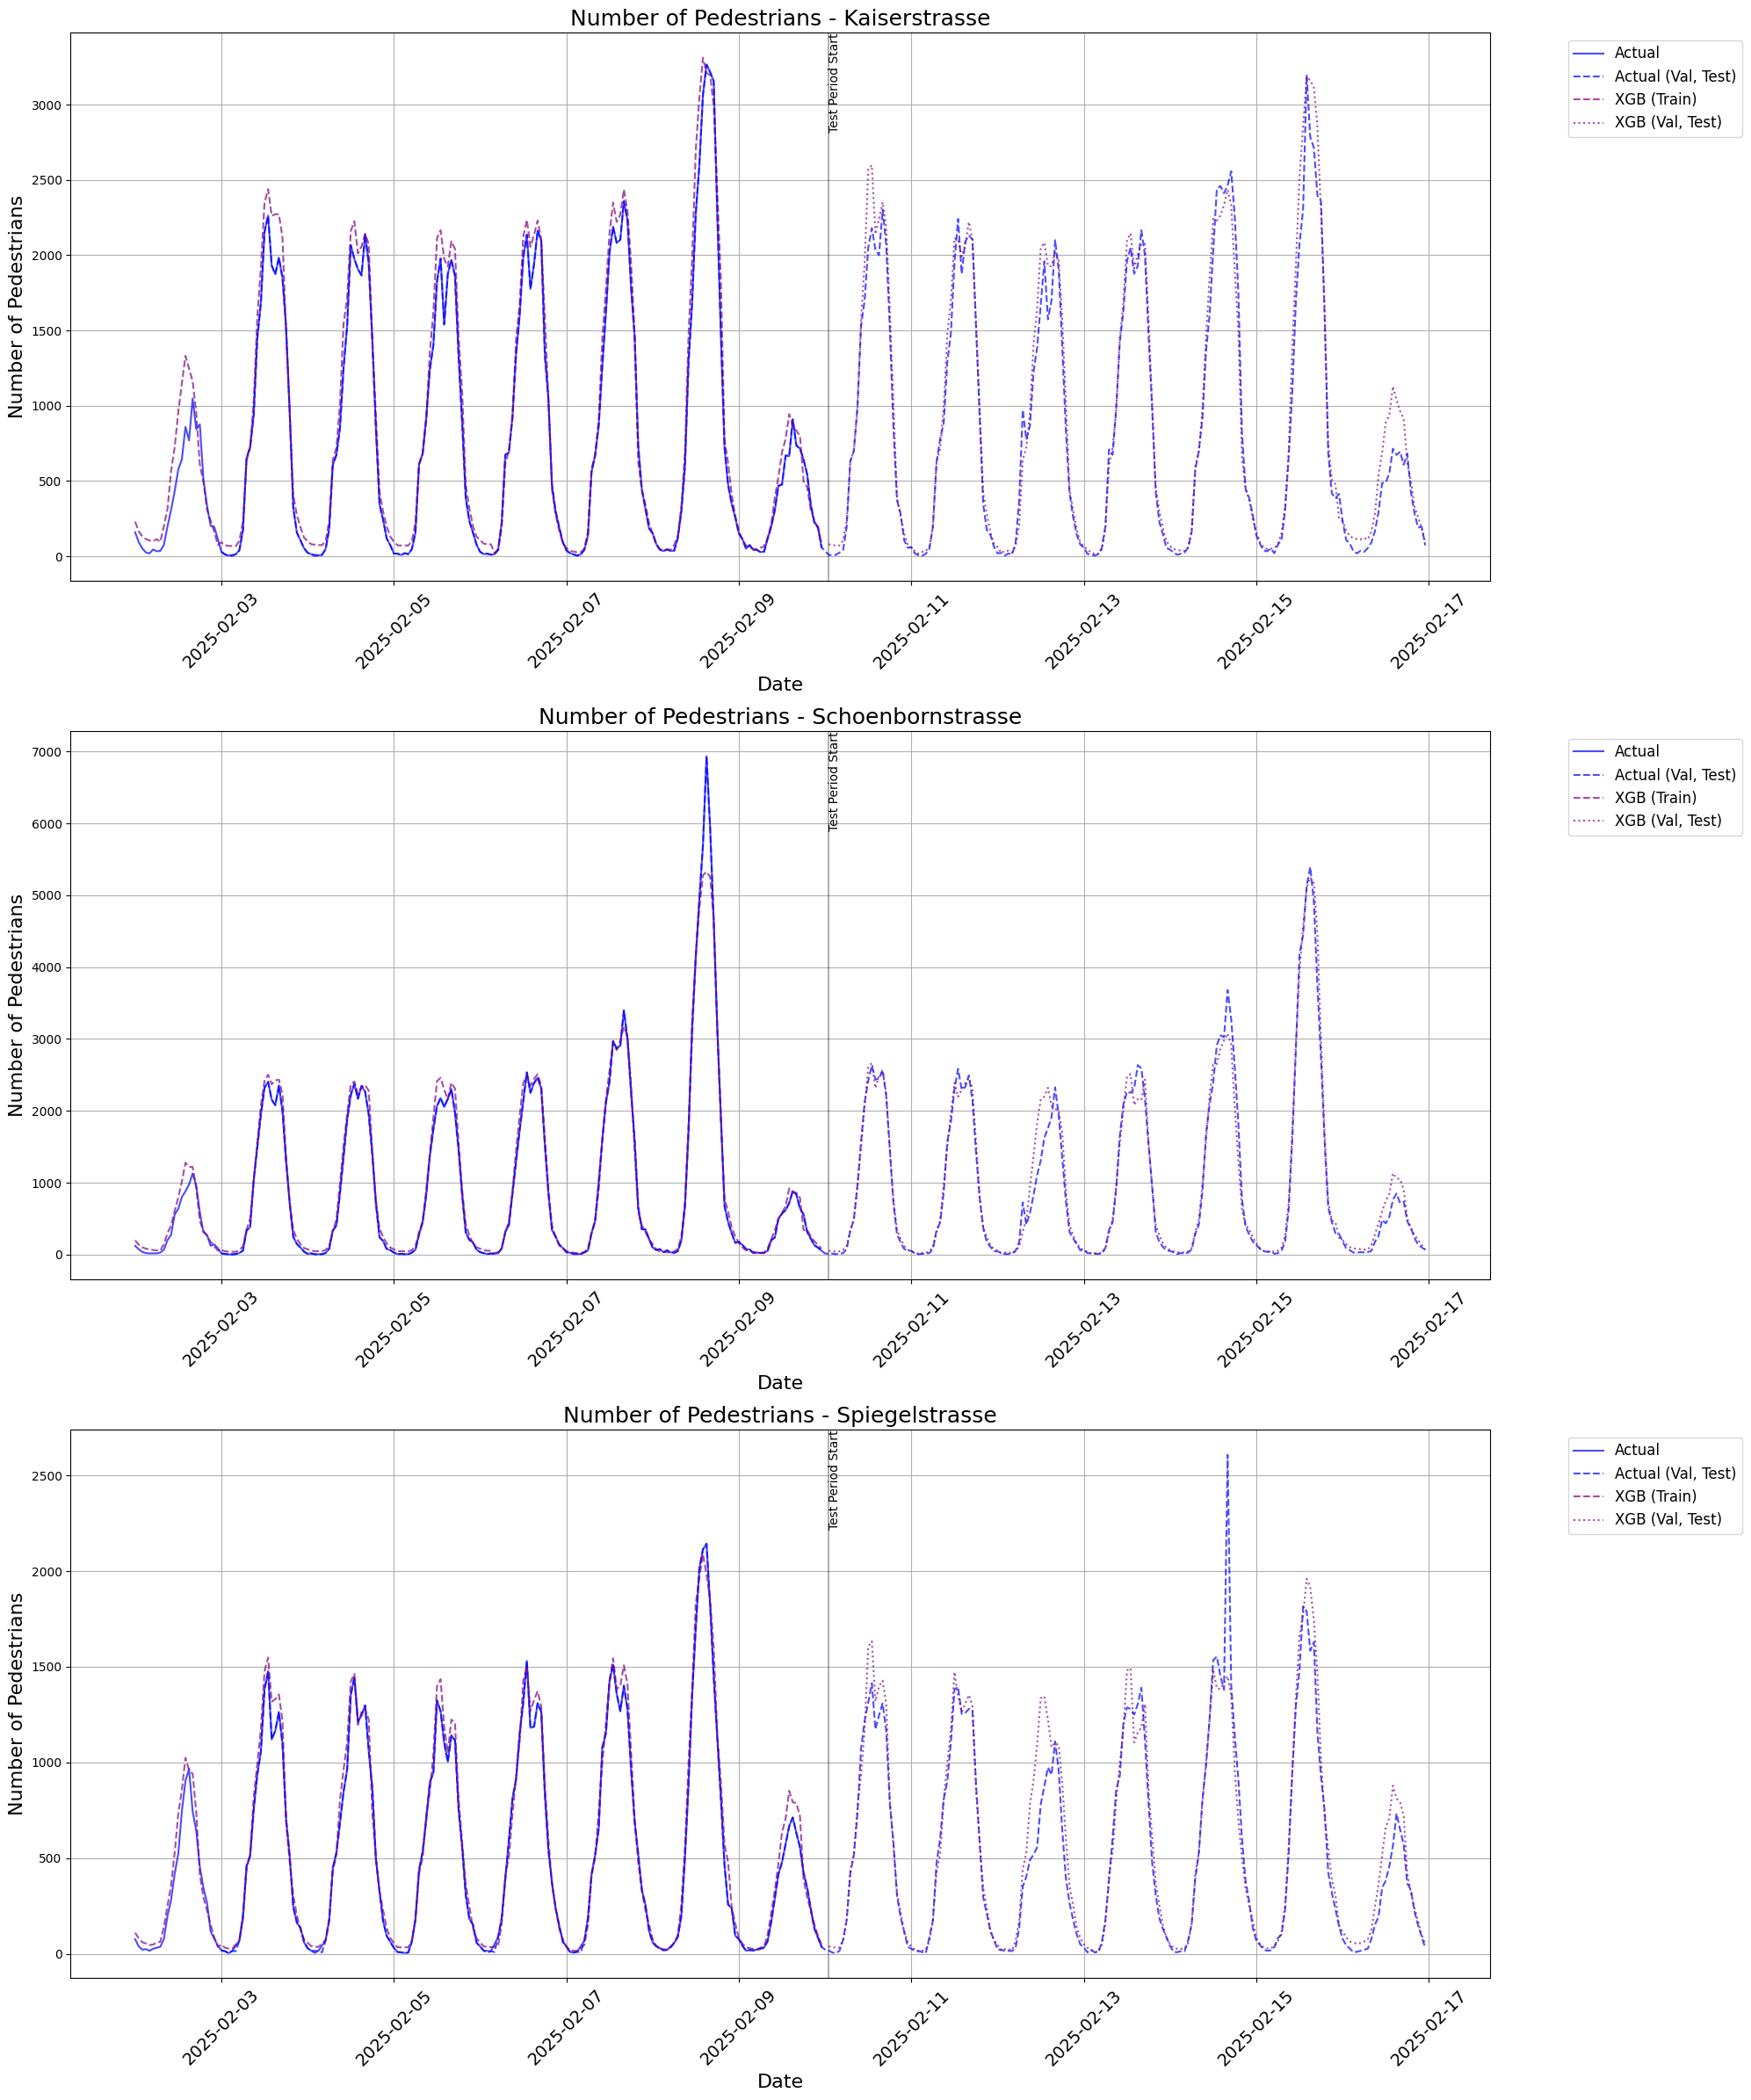


Generating metrics...

Results for n_pedestrians

Overall Metrics:
Model      MSE   RMSE   MAE   MAPE     R2
  XGB 18231.24 135.02 79.57 65.58% 0.9783

Street-wise Metrics:

kaiserstrasse:
Model      MSE   RMSE    MAE   MAPE     R2
  XGB 21664.85 147.19 101.54 82.90% 0.9680

schoenbornstrasse:
Model      MSE   RMSE   MAE   MAPE     R2
  XGB 27470.71 165.74 84.28 72.89% 0.9815

spiegelstrasse:
Model     MSE  RMSE   MAE   MAPE     R2
  XGB 5195.11 72.08 52.04 40.17% 0.9809

Best model for n_pedestrians: XGB (MSE: 18231.24)

Top 10 Important Features for XGB - n_pedestrians:
                      Feature  Importance
            is_shopping_hours    0.778678
             is_tourist_hours    0.113485
     street_schoenbornstrasse    0.010027
             is_working_hours    0.009302
                     is_night    0.008623
                 hour_of_week    0.006809
         street_kaiserstrasse    0.005614
is_schoenbornstrasse_shopping    0.004974
            is_public_holiday    0.004744


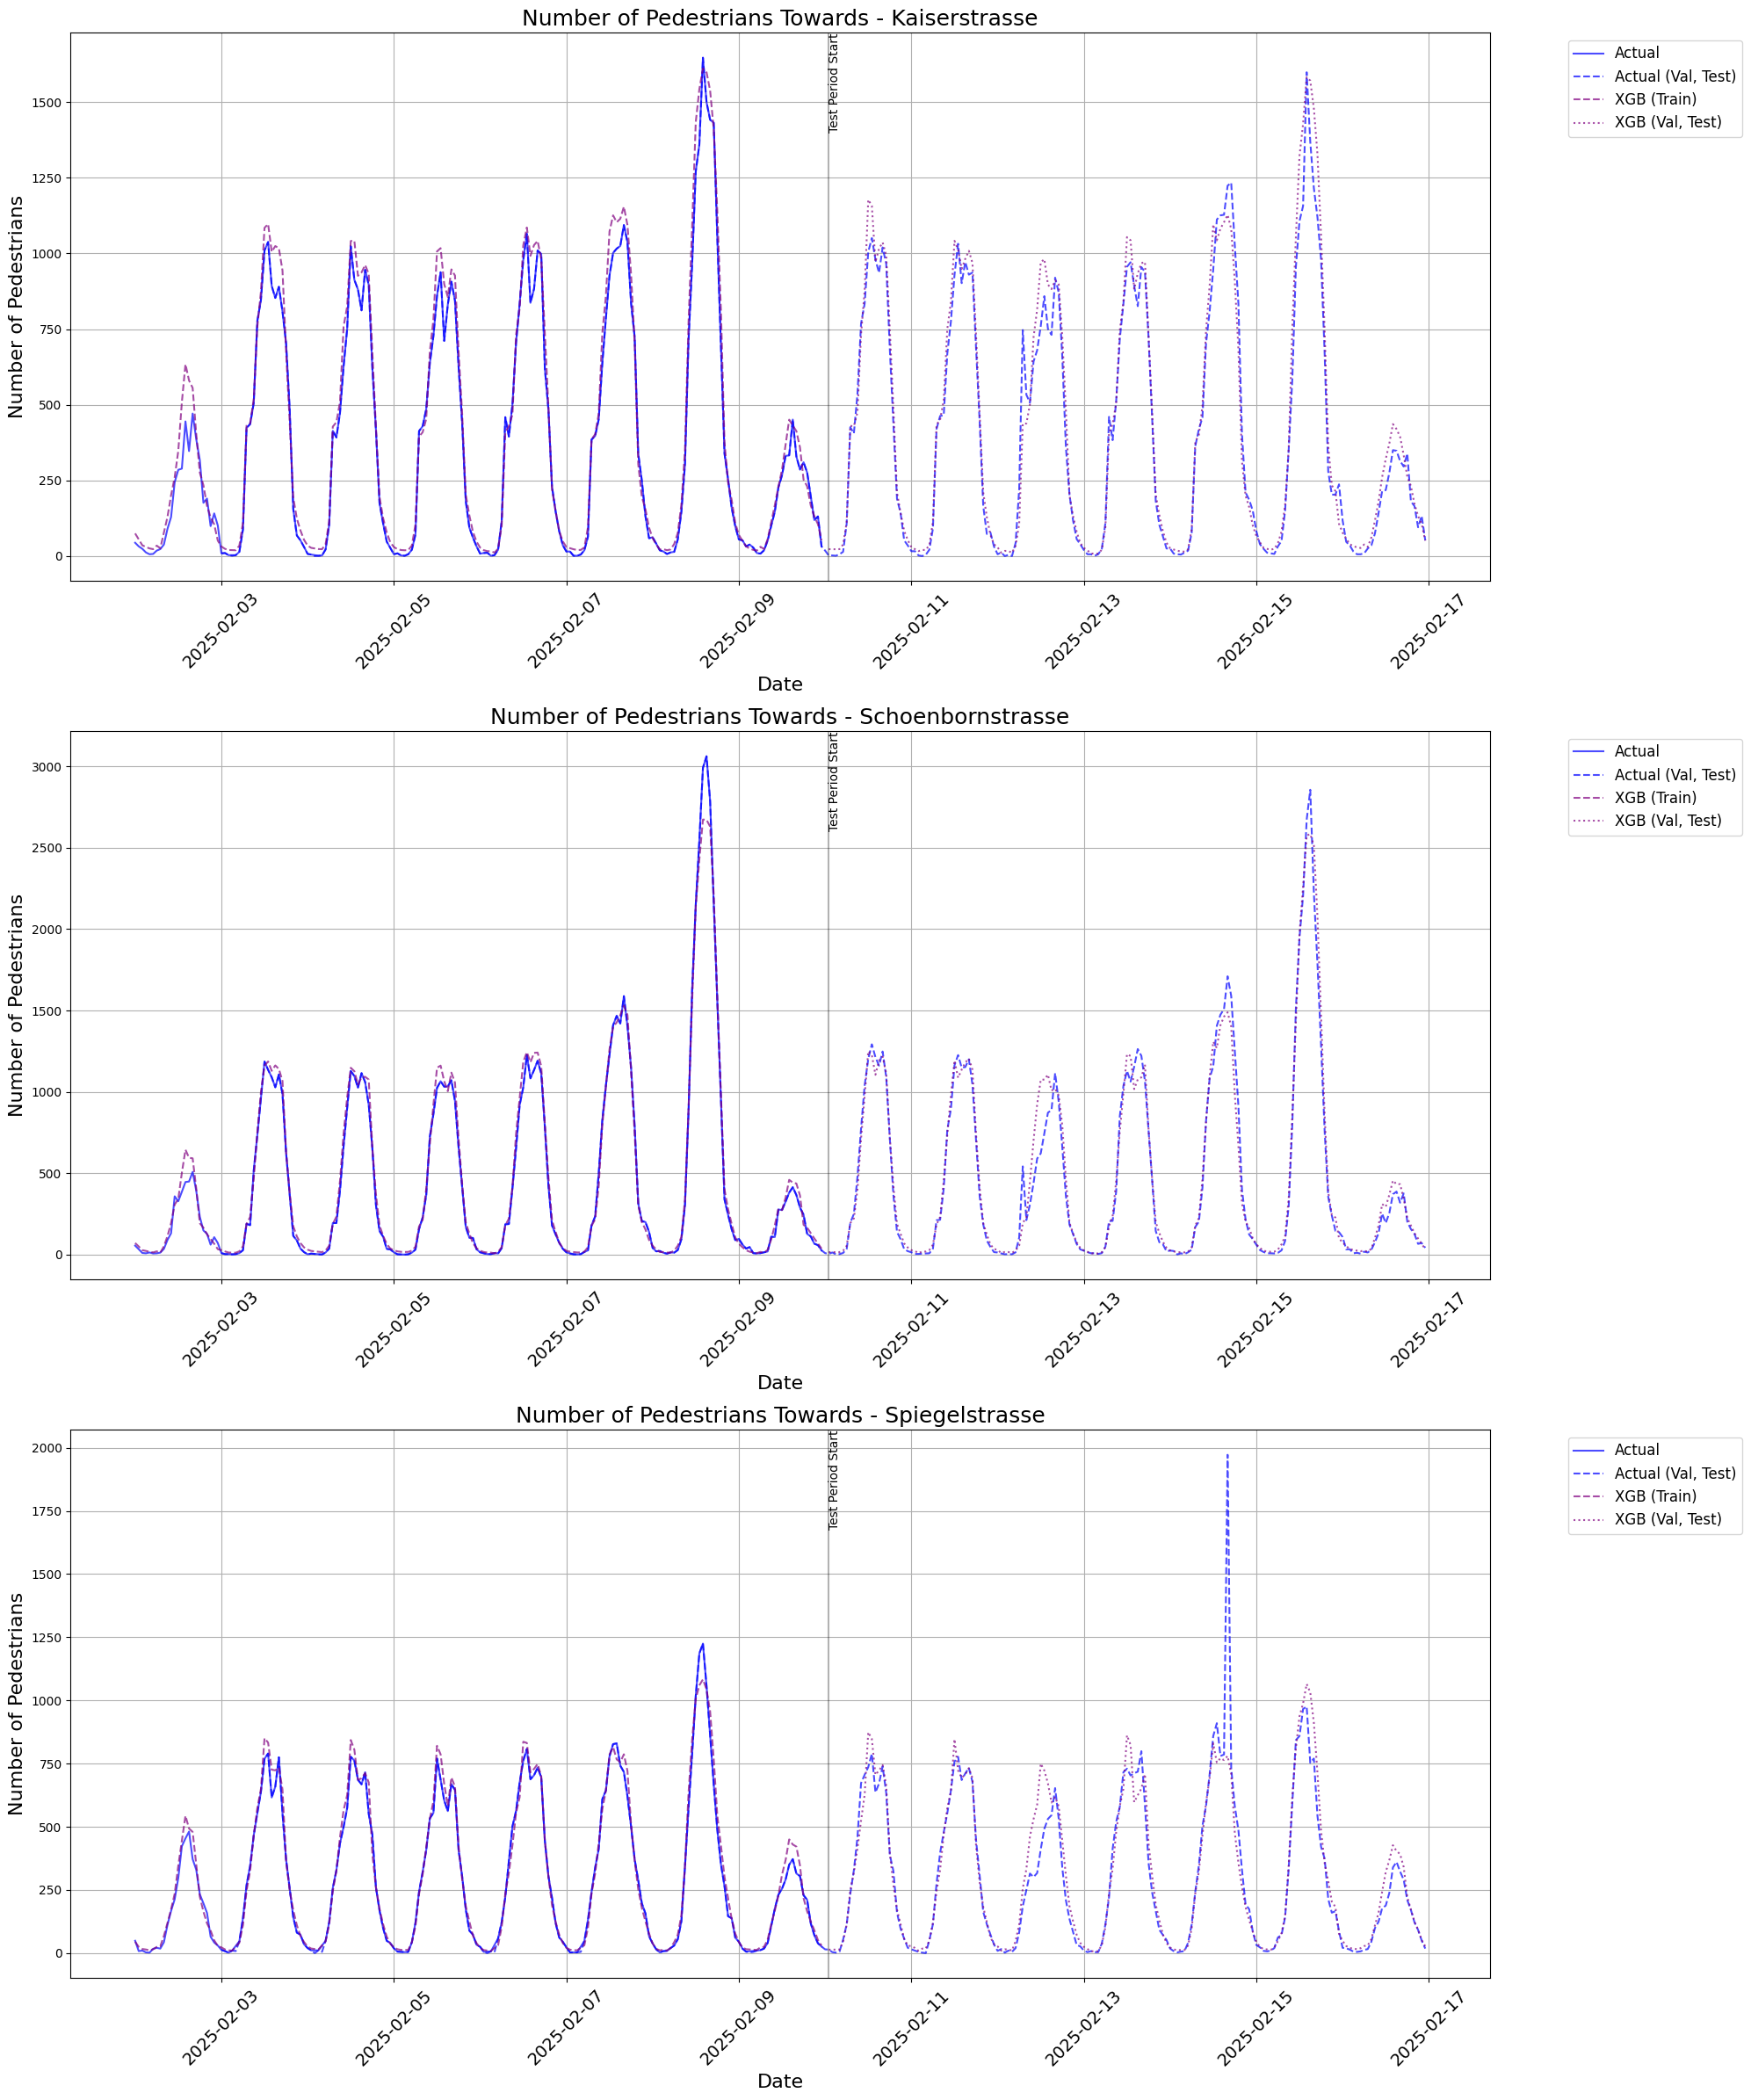


Generating metrics...

Results for n_pedestrians_towards

Overall Metrics:
Model     MSE  RMSE   MAE MAPE     R2
  XGB 3086.39 55.56 35.69 inf% 0.9846

Street-wise Metrics:

kaiserstrasse:
Model     MSE  RMSE   MAE    MAPE     R2
  XGB 3985.23 63.13 43.44 108.26% 0.9743

schoenbornstrasse:
Model     MSE  RMSE   MAE MAPE     R2
  XGB 3636.61 60.30 37.13 inf% 0.9896

spiegelstrasse:
Model     MSE  RMSE   MAE   MAPE     R2
  XGB 1593.08 39.91 26.21 33.62% 0.9809

Best model for n_pedestrians_towards: XGB (MSE: 3086.39)

Top 10 Important Features for XGB - n_pedestrians_towards:
                 Feature  Importance
       is_shopping_hours    0.459005
        is_tourist_hours    0.379144
                is_night    0.034323
        is_working_hours    0.013208
street_schoenbornstrasse    0.011745
         day_of_week_sin    0.009050
            weekend_hour    0.006915
              is_weekend    0.006599
       is_public_holiday    0.006421
            hour_of_week    0.006208


Processi

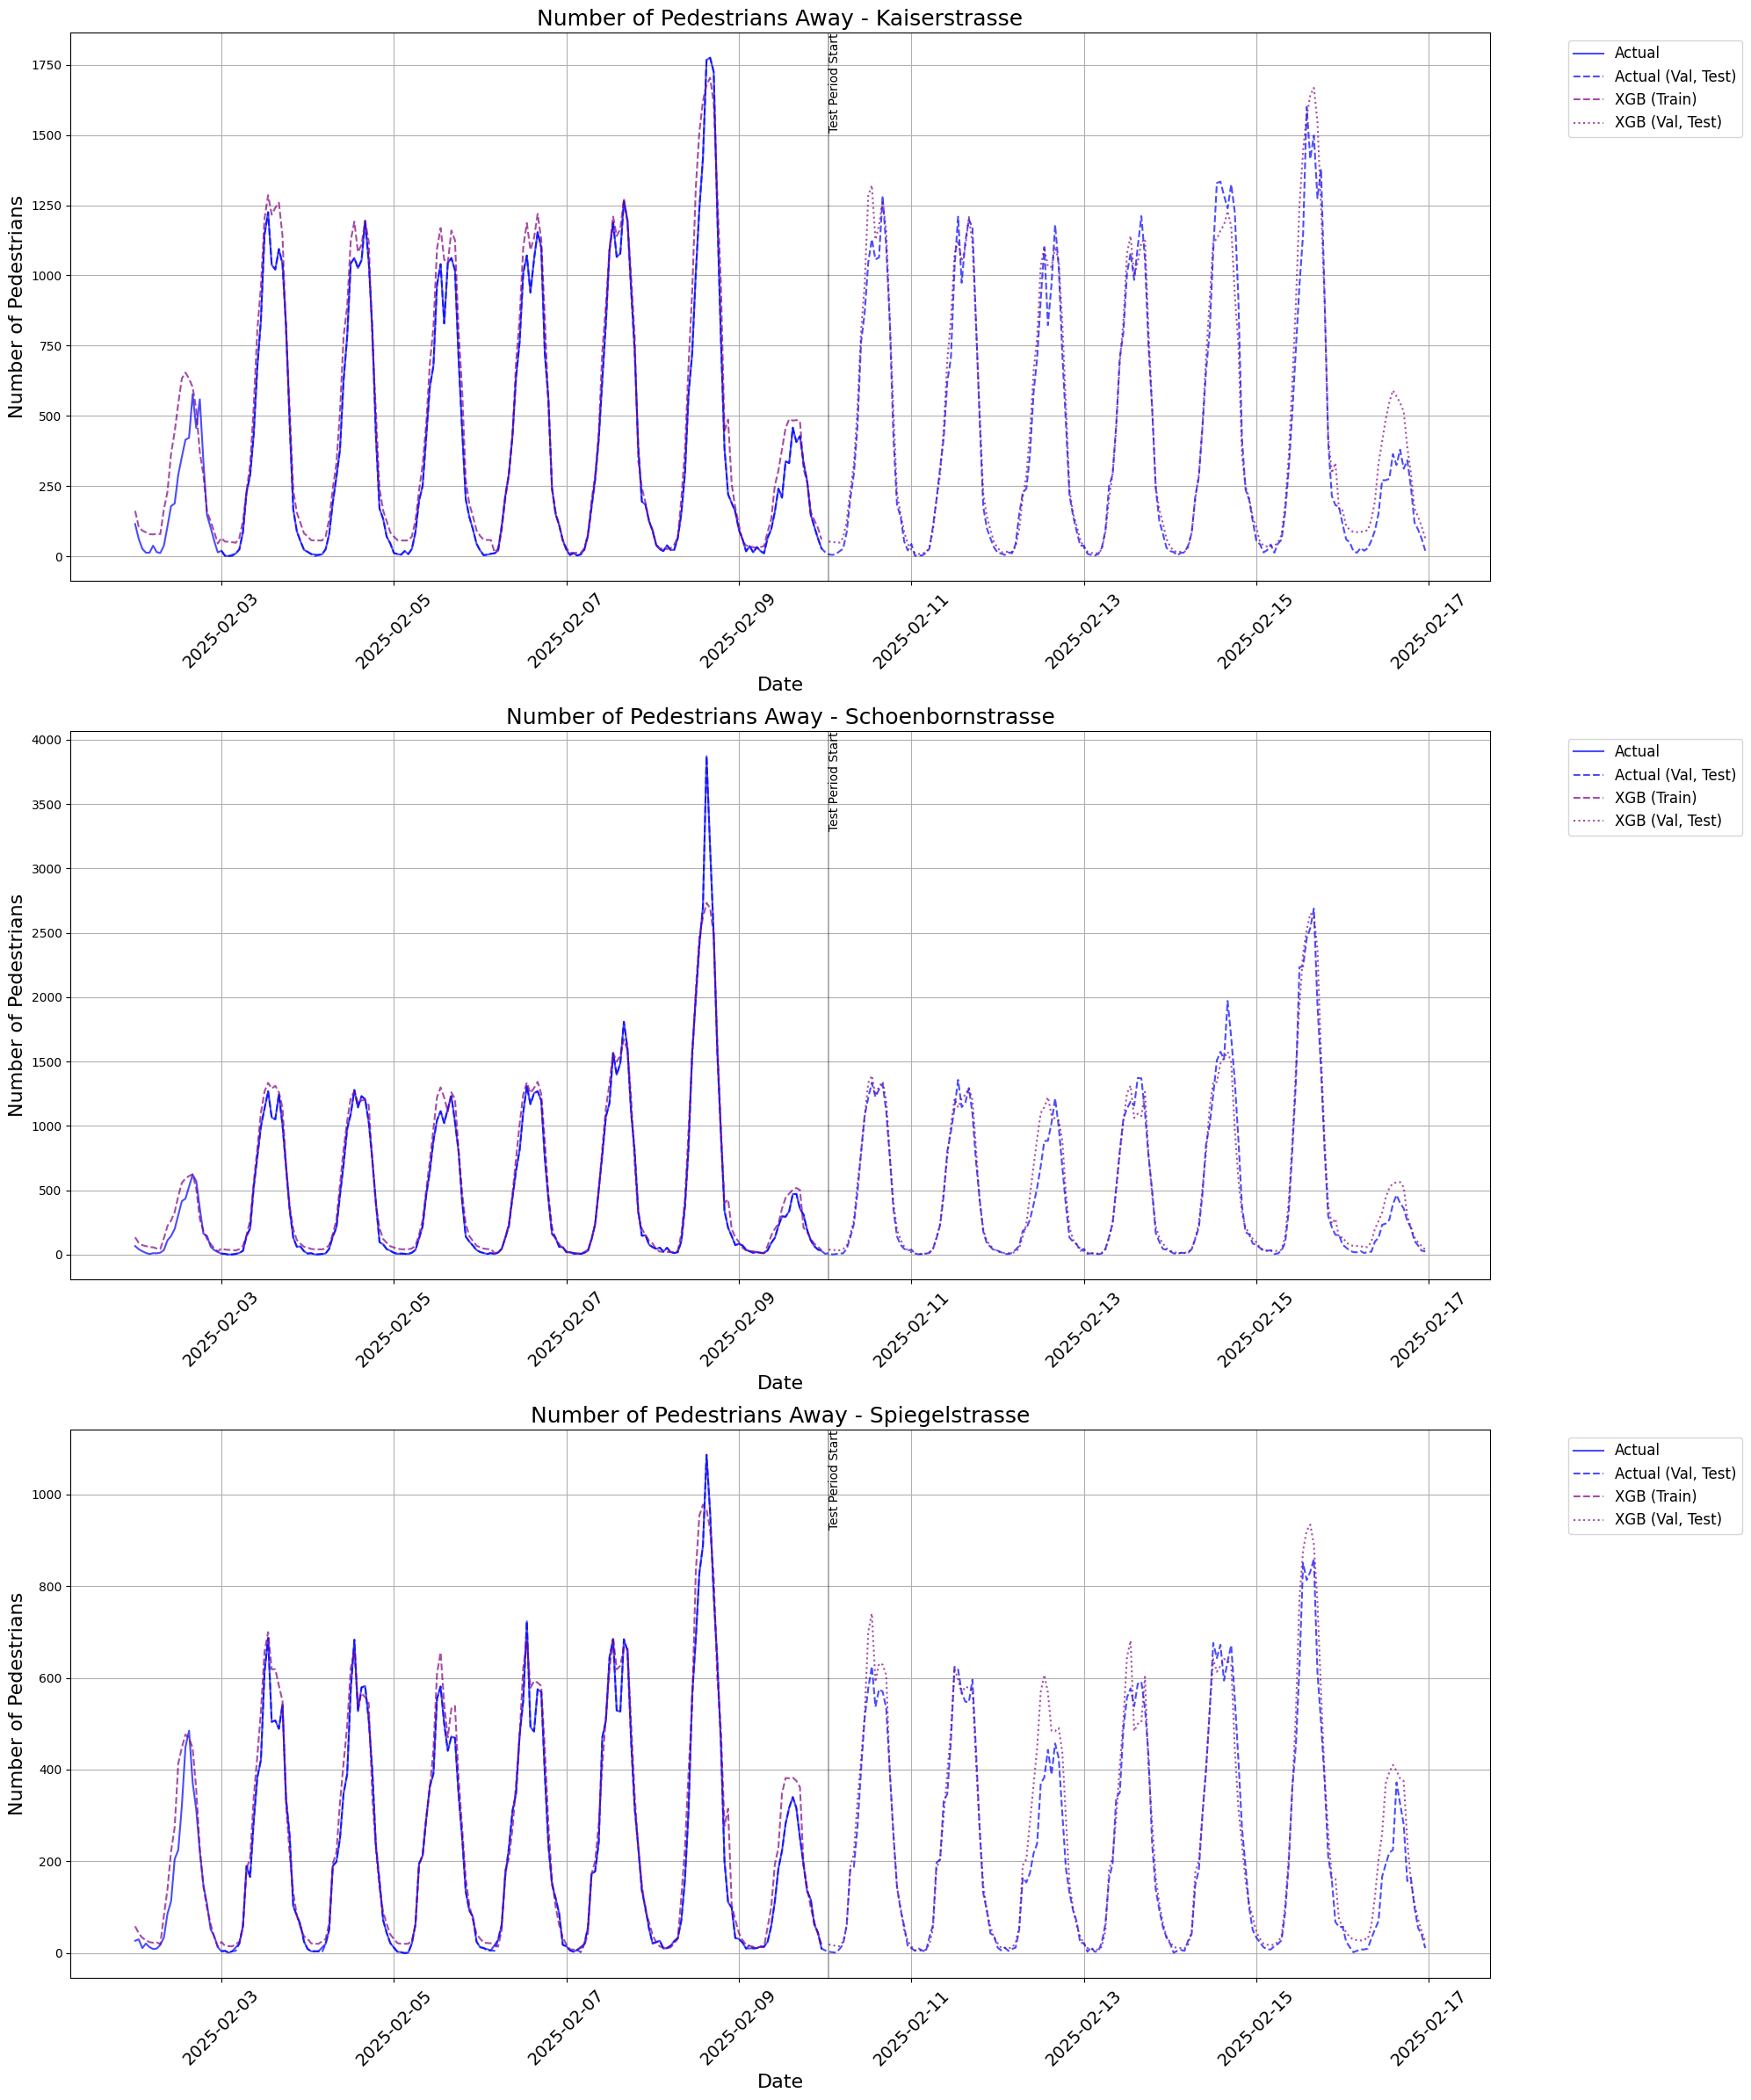


Generating metrics...

Results for n_pedestrians_away

Overall Metrics:
Model     MSE  RMSE   MAE MAPE     R2
  XGB 8244.42 90.80 54.61 inf% 0.9634

Street-wise Metrics:

kaiserstrasse:
Model     MSE  RMSE   MAE    MAPE     R2
  XGB 8582.36 92.64 67.10 134.00% 0.9545

schoenbornstrasse:
Model      MSE   RMSE   MAE MAPE     R2
  XGB 13514.49 116.25 62.60 inf% 0.9660

spiegelstrasse:
Model     MSE  RMSE   MAE MAPE     R2
  XGB 2482.20 49.82 33.52 inf% 0.9561

Best model for n_pedestrians_away: XGB (MSE: 8244.42)

Top 10 Important Features for XGB - n_pedestrians_away:
                   Feature  Importance
         is_shopping_hours    0.808471
          is_tourist_hours    0.093118
is_spiegelstrasse_shopping    0.009296
     street_spiegelstrasse    0.008603
              hour_of_week    0.007511
          is_working_hours    0.007301
  street_schoenbornstrasse    0.006799
                      hour    0.004637
         is_public_holiday    0.004386
              weekend_hour    0.0037

In [20]:
models_selected = {model_name: model for model_name, model in models.items() if model_name in modelsToUse}
targets = ['n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away']

best_models = {}
best_models_saved = {}
target_models = {}
all_val_predictions = {}
all_test_predictions = {}
all_submission_predictions = {}

for target in targets:
    print(f"\nProcessing {target}...")

    if deasonalize:   
        
        seasonal_factors = X_train.groupby(['streetname', 'weekday', 'hour'])[[target]].mean().reset_index().rename({target: 'seasonal_factors'}, axis = 1)
        X_train = X_train.merge(seasonal_factors, on=['streetname', 'weekday', 'hour'], how='left')
        X_train[target] = X_train[target] - X_train['seasonal_factors']
        X_val = X_val.merge(seasonal_factors, on=['streetname', 'weekday', 'hour'], how='left')
        X_val[target] = X_val[target] - X_val['seasonal_factors']
        test_df = test_df.merge(seasonal_factors, on=['streetname', 'weekday', 'hour'], how='left')
        test_df_submission = test_df_submission.merge(seasonal_factors, on=['streetname', 'weekday', 'hour'], how='left')

    val_predictions = {}
    test_predictions = {}
    models_tuned = {}

    for model_name, model in models_selected.items():
        print(f"Training {model_name.upper()}...")

        if tune_model_bool:
            print(f"Starting hyperparameter-tuning for {model_name.upper()}...")
            
            # Tune hyperparameters
            cv_splits = get_cv_splits(X_train, n_splits=n_splits, len_split=168)
            cv_results = tune_model_bayes(model, search_spaces[model_name], X_train[feature_cols], X_train[target], cv_splits, n_iter=n_iter, n_points=n_points_bayesSearch, n_jobs=n_jobs, verbose=verbose)

            model = cv_results.best_estimator_            

            # print(f"Results Tuning {model_name}:{cv_results.cv_results_}")
            print("Best hyperparameters:")
            for param, value in cv_results.best_params_.items():
                print(f"  {param:<20}: {value}")

        else:      
            model.fit(X_train[feature_cols], X_train[target])
        
        val_preds = model.predict(X_val[feature_cols])

        if deasonalize:
            val_preds = val_preds + X_val['seasonal_factors']

        val_preds = np.clip(val_preds, a_min=0, a_max=None)
        val_predictions[model_name] = pd.DataFrame({target: val_preds}, index=X_val.index)

        if retrain_on_val:
            # Combine the training and validation data and retrain the model for the test predictions
            combined_df = pd.concat([X_train, X_val], ignore_index=True)
            model.fit(combined_df[feature_cols], combined_df[target]) 

        models_tuned[model_name] = model

        test_preds = model.predict(test_df[feature_cols])

        if deasonalize:
            test_preds = test_preds + test_df['seasonal_factors']

        test_preds = np.clip(test_preds, a_min=0, a_max=None)
        test_predictions[model_name] = pd.DataFrame({target: test_preds}, index=test_df.index)

        print("Training Complete")

    if deasonalize:
        X_train[target] = X_train[target] + X_train['seasonal_factors']
        X_val[target] = X_val[target] + X_val['seasonal_factors']
    
    all_val_predictions[target] = val_predictions
    all_test_predictions[target] = test_predictions
    
    print(f"\nGenerating comparison plot for {target}...")
    plot_model_comparison(X_val, val_predictions, test_df, test_predictions, val_test_actuals, target)
    
    print("\nGenerating metrics...")
    display_target_metrics(X_val, val_predictions, target)
    
    best_model, best_mse = get_best_model(models_tuned, X_val[target], val_predictions)
    best_models[target] = best_model
    print(f"\nBest model for {target}: {best_model.upper()} (MSE: {best_mse:.2f})")
    
    if best_model in ['rf', 'lgb', 'xgb']:
        display_feature_importance(models_tuned[best_model], feature_cols, best_model, target)

    # Generate the predictions for the submission file using the best_model for the target
    submission_preds = models_tuned[best_model].predict(test_df_submission[feature_cols])

    if deasonalize:
        submission_preds = submission_preds + test_df_submission['seasonal_factors']

    submission_preds = np.clip(submission_preds, a_min=0, a_max=None)
    all_submission_predictions[target] = pd.DataFrame({target: submission_preds}, index=test_df_submission.index)

    target_models[target] = models_tuned
    best_models_saved[target] = copy.deepcopy(models_tuned[best_model])

    if deasonalize:
        X_train.drop(columns=['seasonal_factors'], inplace=True)
        X_val.drop(columns=['seasonal_factors'], inplace=True)
        test_df.drop(columns=['seasonal_factors'], inplace=True)
        test_df_submission.drop(columns=['seasonal_factors'], inplace=True)

with open('best_models.pkl', 'wb') as f:
    pickle.dump(best_models_saved, f)

submission_df = pd.DataFrame({'id': test_df_submission['id']})

for target in targets:
    best_model = best_models[target]
    submission_df[target] = all_submission_predictions[target][target].round(1)

submission_df.to_csv(output_path, index=False)
print(f"\nSubmission file generated: {output_path}")
print("Sample predictions:")
print(submission_df.head())

In [22]:
# Nicely format submission_df for new kaggle competition
test_df_forFormatting = pd.read_csv(os.path.join(workingFolder, 'kaggle_v2/data_foot_traffic', 'test.csv'))

submission_df_formatted = test_df_forFormatting.merge(submission_df, on='id', how='left')

submission_df_formatted = submission_df_formatted[['id', 'streetname', 'city', 
                                                'date', 'hour', 'weekday', 'temperature', 'weather_condition', 'incidents', 'collection_type',
                                                'n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away']]

submission_df_formatted.to_csv(os.path.join(workingFolder, 'kaggle_v2/data_foot_traffic', 'pedestrians_val_test_forecasts.csv'), index=False)

# Performance Score

In [24]:
sub = pd.read_csv(os.path.join(workingFolder, 'kaggle_v2/data_foot_traffic', 'submission.csv'))
solution = pd.read_csv(os.path.join(workingFolder, 'kaggle_v2/data_foot_traffic', 'solution.csv'))
test_data = pd.read_csv(os.path.join(workingFolder, 'kaggle_v2/data_foot_traffic', 'test.csv'))

# Merge the column hour to sub and solution from test_data via the id column
sub = sub.merge(test_data[['id', 'hour']], on='id', how='left')
solution = solution.merge(test_data[['id', 'hour']], on='id', how='left')

targets = ['n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away']

solutionVal = solution[solution.Usage == 'Public']
solutionTest = solution[solution.Usage == 'Private']

# Filter sub to only contain the rows that are in solution
subVal = sub[sub.id.isin(solutionVal.id)]
subTest = sub[sub.id.isin(solutionTest.id)]

subVal = subVal.set_index('id').sort_index()
subTest = subTest.set_index('id').sort_index()

solutionVal = solutionVal.set_index('id').sort_index()
solutionTest = solutionTest.set_index('id').sort_index()

In [25]:
mseVal = np.mean((solutionVal[targets] - subVal[targets])**2)
mseTest = np.mean((solutionTest[targets] - subTest[targets])**2)

print(f"Val-Score: {mseVal}")
print(f"Test-Score: {mseTest}")

Val-Score: 8243.171443779109
Test-Score: 15499.071177248676


In [26]:
# Filter subVal, subTest, solutionVal and solutionTest to only contain data between hour 8 and 22 and compute the MAPE for both
subVal = subVal[(subVal['hour'] >= 8) & (subVal['hour'] <= 22)]
subTest = subTest[(subTest['hour'] >= 8) & (subTest['hour'] <= 22)]
solutionVal = solutionVal[(solutionVal['hour'] >= 8) & (solutionVal['hour'] <= 22)]
solutionTest = solutionTest[(solutionTest['hour'] >= 8) & (solutionTest['hour'] <= 22)]

mapeVal = np.mean(np.abs((solutionVal[targets] - subVal[targets]) / solutionVal[targets])) * 100
mapeTest = np.mean(np.abs((solutionTest[targets] - subTest[targets]) / solutionTest[targets])) * 100

print(f"MAPE Val-Score: {mapeVal}")
print(f"MAPE Test-Score: {mapeTest}")

MAPE Val-Score: 13.620696448657934
MAPE Test-Score: 19.3269316787124


# Uncertainty Quantification / Confidence Intervals

**Prediction intervals from error quantiles — what we’re doing and why**

**Goal.** We want an uncertainty band around our point forecast (\hat{y}) (the model’s mean prediction). Instead of assuming a parametric error model (e.g., Gaussian), we **learn the empirical error distribution from training data** and use its **quantiles** to form **prediction intervals**.

> ⚠️ Strictly speaking these are **prediction intervals** (uncertainty for future observations), not “confidence intervals” (uncertainty about a parameter). We keep the familiar term here, but the object is predictive.

**The basic idea**

1. **Fit your forecasting model** and compute **residuals** on the training set:
   $$
   e = y - \hat{y}.
   $$

2. **Condition on context** (here: `weekday` × `hour`) to capture systematic patterns in the error distribution (e.g., mornings vs. evenings):

   * For each `(weekday, hour)` pair, estimate **empirical quantiles** of the training residuals:
     $$
     q_\alpha(\text{error} \mid \text{weekday}, \text{hour}) .
     $$

3. **Transfer to new data** (val/test):

   * For each new row with the same `(weekday, hour)`, we build quantile forecasts by **shifting the mean prediction** by the corresponding error quantile:
     $$
     \hat{y}_{\alpha} = \hat{y}_{\text{mean}} + q_{\alpha} (\text{error} \mid \text{weekday}, \text{hour}) .
     $$
   * Choosing $\alpha_{\text{low}}$ and $\alpha_{\text{high}}$ (e.g., 0.05 and 0.95) gives a $(1-\alpha)$ prediction interval:
     $$
     [\hat{y}_{\alpha_{\text{low}}}, \hat{y}_{\alpha_{\text{high}}}].
     $$

4. **Clip** values to keep predictions non-negative.

**Why this works (and when it doesn’t)**

* It’s **non-parametric** and **fast**: we reuse model residuals rather than fitting a second model.
* It adapts to **heteroskedasticity** across times of day/days of week via conditioning.
* Assumes **residual stationarity** within each `(weekday, hour)` bucket (i.e., future errors look like past errors).
* If your data regime shifts (events, policy changes, sensors), coverage can drift—recompute error quantiles regularly or condition on richer contexts.

---

**What the plot shows**

For a selected **`target`** and **`street`**, the plot displays over time:

* **Actuals** $y$ — ground-truth series.
* **Predicted mean** $\hat{y}_{\text{mean}}$ — the point forecast from your model.
* **Prediction interval** $([\hat{y}_{\alpha_{\text{low}}}, \hat{y}_{\alpha_{\text{high}}}])$ — constructed via residual quantiles conditioned on `(weekday, hour)`.

Interpretation:

* When the **actual line** lies mostly within the band, your interval coverage is close to its nominal level (e.g., ~90% for ([0.05, 0.95])).
* **Wider bands** indicate higher historical uncertainty for those times (e.g., weekend afternoons).
* **Systematic departures** (actuals often outside the band) suggest miscalibration—consider updating the conditioning set, re-fitting quantiles, or revisiting the base model.

---

**Practical tips**

* Choose quantiles to match your desired coverage (e.g., 0.05/0.95 for 90%).
* Bucketing by `(weekday, hour)` is a good baseline; adding season, weather, or location can improve calibration (watch sample sizes).
* Recompute error quantiles when you retrain the model or observe drift.
* Report **empirical coverage** on validation to verify calibration:
  $$
  \frac{1}{n} \sum_{t=1}^n \mathbf{1} \{\hat{y}_{\alpha_{\text{low},t}} \leq y_t \leq \hat{y}_{\alpha_{\text{high},t}} \}.
  $$


In [27]:
quantiles = [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99, 0.995]
cols_to_keep = ['id', 'streetname', 'date', 'hour', 'weekday']

cols_order_output = ['id', 'streetname', 'target', 'date', 'hour', 'weekday', 'actual', 'pred_mean',
                    'quantile', 'error_quantile', 'pred_quantile', 'error_pred_quantile']

pred_results_train = []
pred_results_val = []
pred_results_test = []

for target in ['n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away']:
    model = best_models_saved[target]
    
    for street in X_train['streetname'].unique():

        X_train_street = X_train[X_train['streetname'] == street].copy()

        X_train_street['pred_mean'] = np.clip(model.predict(X_train_street[feature_cols]), a_min=0, a_max=None)
        X_train_street['error'] = X_train_street[target] - X_train_street['pred_mean']

        # Calculate the quantiles of the column error per hour and add them as a new column
        error_quantiles = X_train_street.groupby(['weekday', 'hour'])['error'].quantile(quantiles).unstack().reset_index()
        error_quantiles = error_quantiles.melt(id_vars=['weekday', 'hour'], value_vars=quantiles, var_name='quantile', value_name='error_quantile')

        #---

        # Merge the quantiles back to X_train_street
        pred_results_train_street = X_train_street[cols_to_keep + [target] + ['pred_mean']].merge(error_quantiles, on=['weekday', 'hour'], how='right')
        pred_results_train_street.reset_index(drop=True, inplace=True)

        pred_results_train_street['pred_quantile'] = np.clip(pred_results_train_street['pred_mean'] + pred_results_train_street['error_quantile'], a_min=0, a_max=None)

        pred_results_train_street['target'] = target
        pred_results_train_street.rename({target: 'actual'}, axis=1, inplace=True)

        pred_results_train_street['error_pred_quantile'] = pred_results_train_street['actual'] - pred_results_train_street['pred_quantile']

        pred_results_train.append(pred_results_train_street)
        
        #---
        
        # 
        
        X_val_street = X_val[X_val['streetname'] == street].copy()
        X_val_street['pred_mean'] = np.clip(model.predict(X_val_street[feature_cols]), a_min=0, a_max=None)

        # Merge error_quantiles calculated based on X_train to X_val_street
        pred_results_val_street = X_val_street[cols_to_keep + [target] + ['pred_mean']].merge(error_quantiles, on=['weekday', 'hour'], how='right')
        pred_results_val_street.reset_index(drop=True, inplace=True)
        
        pred_results_val_street['pred_quantile'] = np.clip(pred_results_val_street['pred_mean'] + pred_results_val_street['error_quantile'], a_min=0, a_max=None)
        
        pred_results_val_street['target'] = target
        pred_results_val_street.rename({target: 'actual'}, axis=1, inplace=True)
        
        pred_results_val_street['error_pred_quantile'] = pred_results_val_street['actual'] - pred_results_val_street['pred_quantile']
        
        pred_results_val.append(pred_results_val_street)
        
        #---
        
        test_df_street = test_df_submission[test_df_submission['streetname'] == street].copy()
        test_df_street['pred_mean'] = np.clip(model.predict(test_df_street[feature_cols]), a_min=0, a_max=None)
        
        # Merge error_quantiles calculated based on X_train to test_df_street
        pred_results_test_street = test_df_street[cols_to_keep + ['pred_mean']].merge(error_quantiles, on=['weekday', 'hour'], how='right')
        pred_results_test_street.reset_index(drop=True, inplace=True)
        
        pred_results_test_street['pred_quantile'] = np.clip(pred_results_test_street['pred_mean'] + pred_results_test_street['error_quantile'], a_min=0, a_max=None)
        pred_results_test_street['actual'] = np.nan
        pred_results_test_street['target'] = target
        pred_results_test_street['error_pred_quantile'] = np.nan

        pred_results_test.append(pred_results_test_street)

pred_results_train = pd.concat(pred_results_train, ignore_index=True)
pred_results_val = pd.concat(pred_results_val, ignore_index=True)
pred_results_test = pd.concat(pred_results_test, ignore_index=True)

pred_results_train = pred_results_train[cols_order_output]
pred_results_val = pred_results_val[cols_order_output]
pred_results_test = pred_results_test[cols_order_output]

In [28]:
# Check if confidence intervals are well calibrated. The empirical coverage should be at least as high as the nominal coverage and as close to the nominal coverage as possible.
# For example, for the 95% quantile, the empirical coverage should be at least 95% (i.e., the actual value is below the predicted 95% quantile at least 95% of the time).
pred_results_val.groupby(['target', 'quantile'])['error_pred_quantile'].agg(lambda x: np.mean(x < 0))

target                 quantile
n_pedestrians          0.005       0.165505
                       0.010       0.174216
                       0.025       0.216028
                       0.050       0.263066
                       0.100       0.341463
                       0.250       0.548780
                       0.500       0.743902
                       0.750       0.898955
                       0.900       0.951220
                       0.950       0.966899
                       0.975       0.966899
                       0.990       0.970383
                       0.995       0.973868
n_pedestrians_away     0.005       0.233449
                       0.010       0.252613
                       0.025       0.290941
                       0.050       0.353659
                       0.100       0.444251
                       0.250       0.599303
                       0.500       0.773519
                       0.750       0.916376
                       0.900       0.958188


In [69]:
def plot_prediction_intervals(df: pd.DataFrame,
                              target: str,
                              street: str,
                              lower_q: float = 0.05,
                              upper_q: float = 0.95,
                              date_col: str = "date",
                              hour_col: str = "hour",
                              title: str = None):
    """
    Plot prediction interval [lower_q, upper_q], mean prediction, and actuals
    for a given target and street.
    
    If actuals are not available, only the prediction interval and mean prediction are shown.
    
    IMPORTANT: The function is only suited to plot short time frames (e.g. a few weeks).
    For longer time frames, consider resampling the data (e.g. daily averages).

    Assumes df has multiple rows per timestamp (one per quantile). We aggregate:
      - quantile predictions: mean per (timestamp, quantile)
      - pred_mean / actual: mean per timestamp

    Required columns in df:
      'streetname', 'target', date_col, hour_col,
      'actual', 'pred_mean', 'pred_quantile', 'quantile'
    """

    # Filter to one target & street
    df = df[(df["target"] == target) & (df["streetname"] == street)].copy()
    if df.empty:
        raise ValueError(f"No rows for target='{target}' and street='{street}'.")
    
    # Ensure the actual column exist. It is ignored if not available.
    if "actual" not in df.columns:
        df["actual"] = np.nan  # Placeholder if actuals not available

    # Build timestamp
    df["timestamp"] = pd.to_datetime(df[date_col]) + pd.to_timedelta(df[hour_col], unit="h")

    # --- Aggregate so indices are unique ---
    # 1) Quantiles as columns (average in case of duplicates)
    df_quant = df.pivot_table(index="timestamp",
                            columns="quantile",
                            values="pred_quantile",
                            aggfunc="mean")

    # 2) Mean prediction and actuals per timestamp (average if duplicates)
    df_mean = (df.groupby("timestamp")[["pred_mean", "actual"]]
                .mean()
                .sort_index())

    # Align on the intersection of timestamps
    common_idx = df_mean.index.intersection(df_quant.index)
    df_mean = df_mean.loc[common_idx]
    df_quant = df_quant.loc[common_idx]

    # Check quantile columns exist
    if lower_q not in df_quant.columns or upper_q not in df_quant.columns:
        available = ", ".join(str(q) for q in df_quant.columns.tolist())
        raise ValueError(
            f"Requested quantiles ({lower_q}, {upper_q}) not found. "
            f"Available: {available}"
        )

    lower = df_quant[lower_q]
    upper = df_quant[upper_q]

    # --- Plot ---
    
    # Format label for the intervalls: Multiply by 100 and write it as percent
    lower_label = round(lower_q * 100, 1)
    upper_label = round(upper_q * 100, 1)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.fill_between(df_quant.index, lower, upper, alpha=0.2,
                    label=f"Interval [{lower_label}%, {upper_label}%]")
    ax.plot(df_mean.index, df_mean["pred_mean"], label="Predicted Mean")

    ax.plot(df_mean.index, df_mean["actual"], label="Actual")

    # Add title formatting: n_pedestrians -> Number of Pedestrians, n_pedestrians_towards -> Number of Pedestrians Towards, etc.
    if target == "n_pedestrians":
        title = f"Number of Pedestrians - {street.capitalize()}"
    elif target == "n_pedestrians_towards":
        title = f"Number of Pedestrians Towards - {street.capitalize()}"
    elif target == "n_pedestrians_away":
        title = f"Number of Pedestrians Away - {street.capitalize()}"
        
    ax.set_title(title or f"{target} – {street}")
    ax.set_xlabel("Time")
    ax.set_ylabel(target)
    ax.legend()
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


In [66]:
train_df.iloc[:, 0:20][-20:-15]

,id,streetname,date,hour,weekday,n_pedestrians,n_pedestrians_towards,n_pedestrians_away,temperature,incidents,collection_type,datetime,year,month,day,day_of_week,hour_of_week,hour_sin,hour_cos,day_of_week_sin
71660,spiegelstrasse_2025-02-09_17,spiegelstrasse,2025-02-09,17,Sunday,556,305,251,3,no_incident,measured,2025-02-09 17:00:00,2025,2,9,6,161,-0.965926,-2.588190e-01,-0.781831
71661,schoenbornstrasse_2025-02-09_17,schoenbornstrasse,2025-02-09,17,Sunday,645,289,356,3,no_incident,measured,2025-02-09 17:00:00,2025,2,9,6,161,-0.965926,-2.588190e-01,-0.781831
71662,spiegelstrasse_2025-02-09_18,spiegelstrasse,2025-02-09,18,Sunday,422,229,193,1,no_incident,measured,2025-02-09 18:00:00,2025,2,9,6,162,-1.000000,-1.836970e-16,-0.781831
71663,kaiserstrasse_2025-02-09_18,kaiserstrasse,2025-02-09,18,Sunday,643,310,333,1,no_incident,measured,2025-02-09 18:00:00,2025,2,9,6,162,-1.000000,-1.836970e-16,-0.781831
71664,schoenbornstrasse_2025-02-09_18,schoenbornstrasse,2025-02-09,18,Sunday,556,245,311,1,no_incident,measured,2025-02-09 18:00:00,2025,2,9,6,162,-1.000000,-1.836970e-16,-0.781831


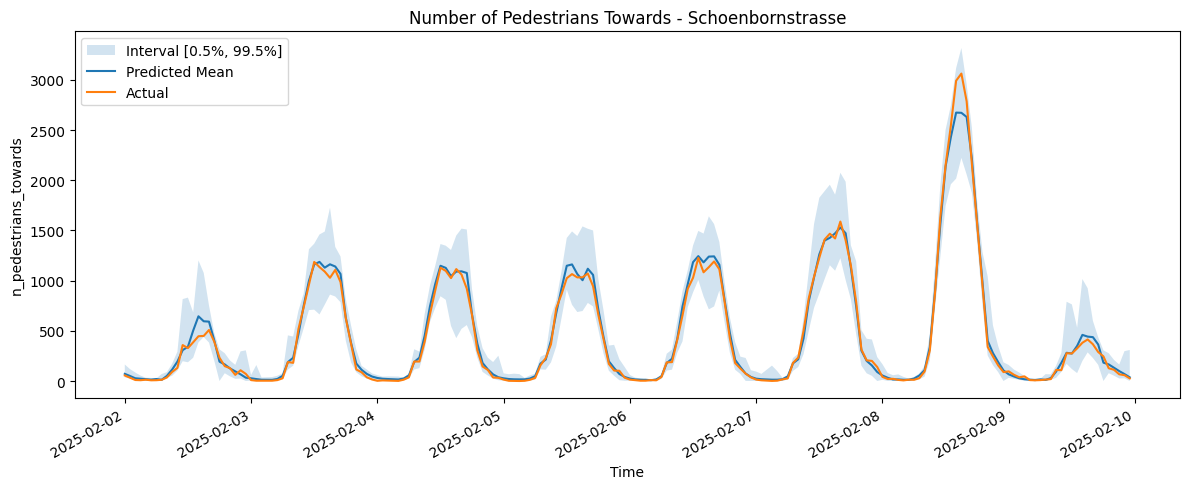

In [70]:
plot_prediction_intervals(pred_results_val, target="n_pedestrians_towards", street="schoenbornstrasse",
                        lower_q=0.005, upper_q=0.995)

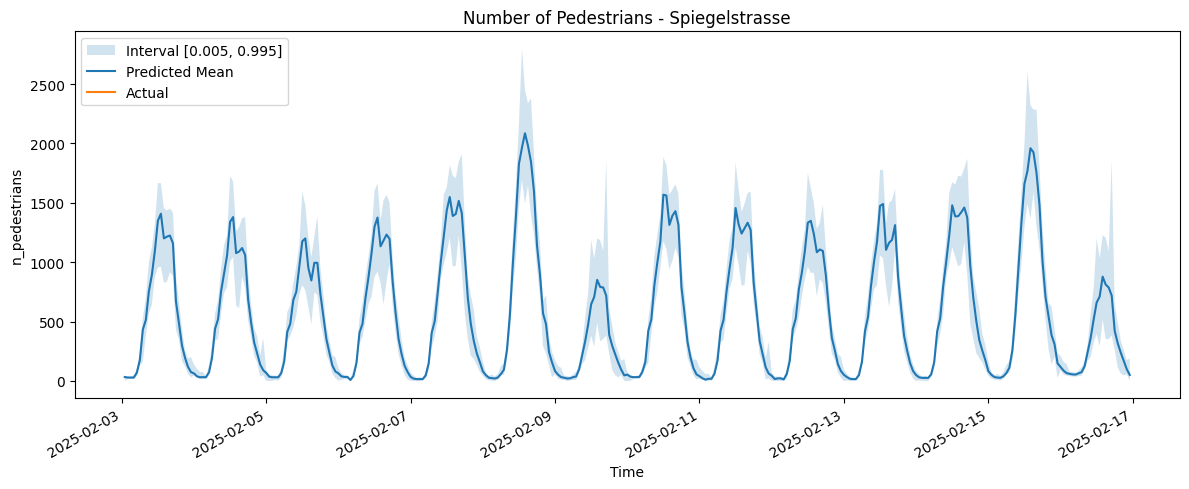

In [33]:
plot_prediction_intervals(pred_results_test, target="n_pedestrians", street="spiegelstrasse",
                        lower_q=0.005, upper_q=0.995)

# SHAP

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[20:06:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[20:06:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


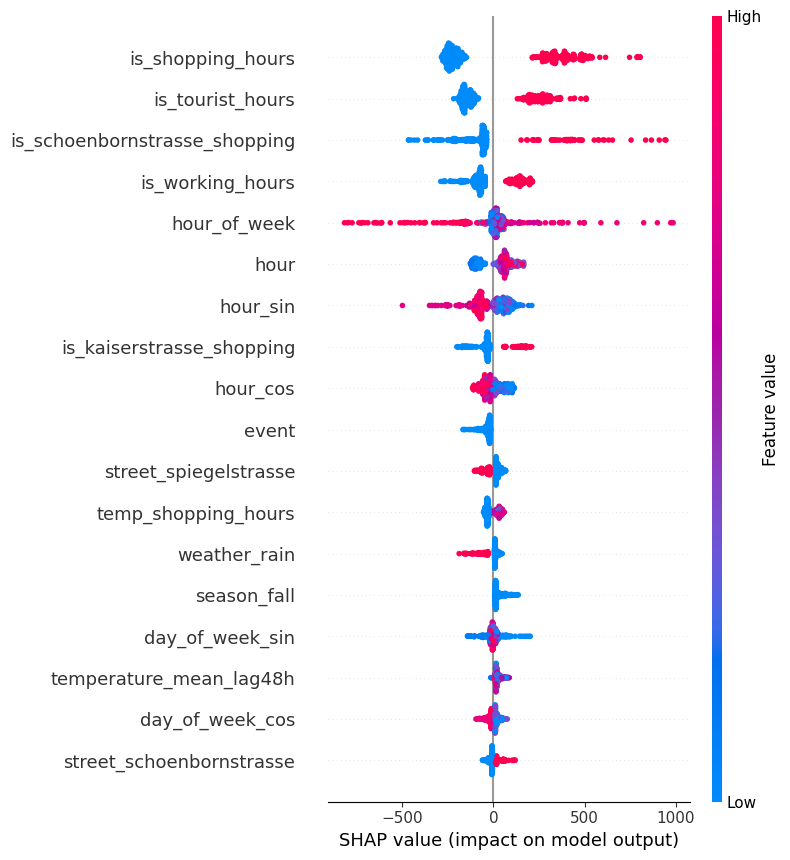

In [22]:
import shap

# Create a SHAP explainer
explainer = shap.Explainer(best_models_saved['n_pedestrians'])

# Compute SHAP values
shap_values = explainer(test_df[feature_cols])  # Use test data or a sample of it

# Plot summary
shap.summary_plot(shap_values, test_df[feature_cols], max_display = 18)

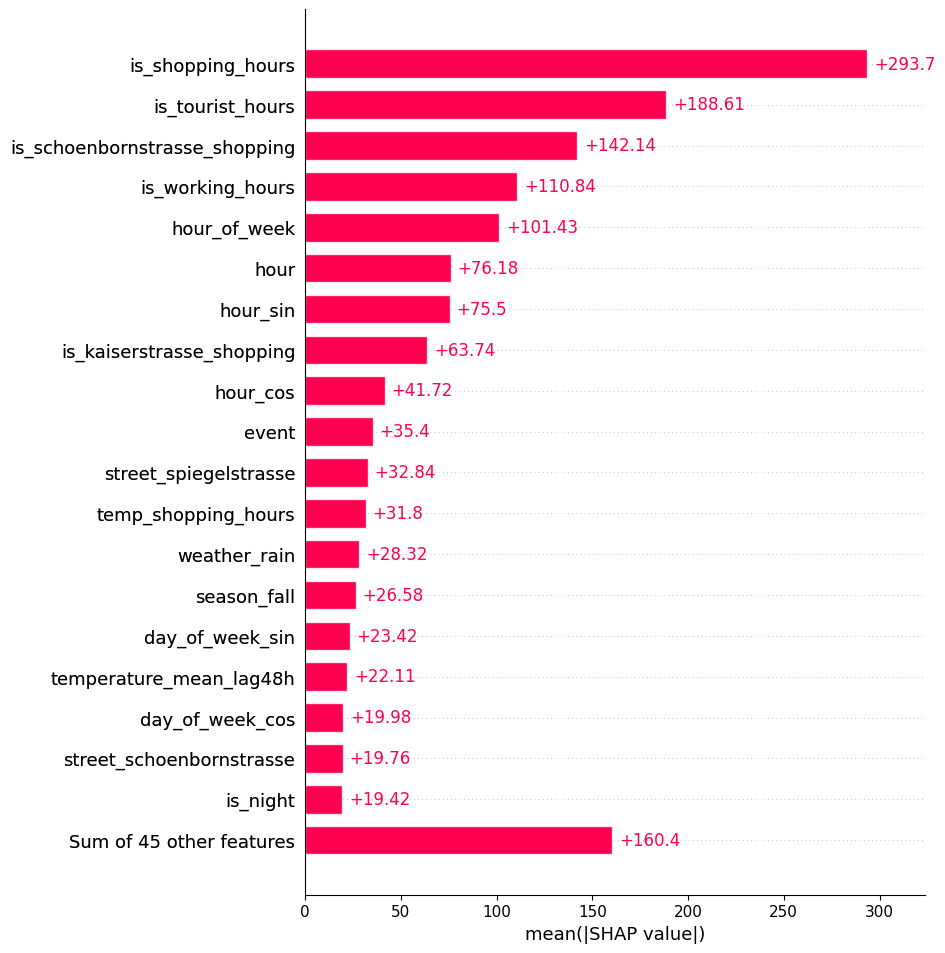

In [23]:
# Plot the feature importance using SHAP values
shap.plots.bar(shap_values, max_display=20)